<img src="https://raw.githubusercontent.com/AmsterdamUMC/AmsterdamUMCdb/master/img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb Scientific Paper

Manuscript submitted for publication. Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

## Table 1
The code in this notebook creates *Table 1* from the AmsterdamUMCdb manuscript.

To run this notebook succesfully the following notebooks have to be run in advance:
- [create_dictionaries](../dictionaries/create_dictionaries)
- [apache_ii](../concepts/severityscores/apache_ii.ipynb)
- [sofa](../concepts/severityscores/sofa.ipynb)

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

# Table 1. Characteristics of patients and data in AmsterdamUMCdb

In [4]:
#since this is a small table, we can load all data
sql = """
SELECT * FROM admissions;
"""
admissions = pd.read_sql(sql,con)

In [5]:
#No. patients
no_patients_total = admissions.patientid.nunique()
no_patients_ICU = admissions[admissions['location'].str.contains('IC')].patientid.nunique()
no_patients_MCU = admissions[admissions['location'].str.contains('^MC$')].patientid.nunique()

#No. admissions
no_admissions_total = admissions.admissionid.nunique()
no_admissions_ICU = admissions[admissions['location'].str.contains('IC')].admissionid.nunique()
no_admissions_MCU = admissions[admissions['location'].str.contains('^MC$')].admissionid.nunique()

#Length of stay
los_total = admissions.lengthofstay.median()/24 
los_iqr1_total = admissions.lengthofstay.quantile(0.25)/24
los_iqr2_total = admissions.lengthofstay.quantile(0.75)/24

los_ICU = admissions[admissions['location'].str.contains('IC')].lengthofstay.median()/24
los_iqr1_ICU = admissions[admissions['location'].str.contains('IC')].lengthofstay.quantile(0.25)/24
los_iqr2_ICU = admissions[admissions['location'].str.contains('IC')].lengthofstay.quantile(0.75)/24

los_MCU = admissions[admissions['location'].str.contains('^MC$')].lengthofstay.median()/24
los_iqr1_MCU = admissions[admissions['location'].str.contains('^MC$')].lengthofstay.quantile(0.25)/24
los_iqr2_MCU = admissions[admissions['location'].str.contains('^MC$')].lengthofstay.quantile(0.75)/24

#Gender
## Male
male_total = len(admissions.loc[(admissions['gender'] == 'Man') & (admissions['admissioncount'] == 1)]['gender'])
male_pct_total = 100*male_total/no_patients_total

male_ICU = len(admissions.loc[(admissions['location'].str.contains('IC')) & (admissions['gender'] == 'Man') & (admissions['admissioncount'] == 1)]['gender'])
male_pct_ICU = 100*male_ICU/no_patients_ICU

male_MCU = len(admissions.loc[(admissions['location'].str.contains('^MC$')) & (admissions['gender'] == 'Man') & (admissions['admissioncount'] == 1)]['gender'])
male_pct_MCU = 100*male_MCU/no_patients_MCU


## Female
female_total = len(admissions.loc[(admissions['gender'] =='Vrouw') & (admissions['admissioncount'] == 1)]['gender'])
female_pct_total = 100*female_total/no_patients_total

female_ICU = len(admissions.loc[(admissions['location'].str.contains('IC')) & (admissions['gender'] =='Vrouw') & (admissions['admissioncount'] == 1)]['gender'])
female_pct_ICU = 100*female_ICU/no_patients_ICU

female_MCU = len(admissions.loc[(admissions['location'].str.contains('^MC$')) & (admissions['gender'] =='Vrouw') & (admissions['admissioncount'] == 1)]['gender'])
female_pct_MCU = 100*female_MCU/no_patients_MCU

## Unknown
gender_na_total = len(admissions.loc[(admissions['gender'] == '') & (admissions['admissioncount'] == 1)]['gender'])
gender_na_pct_total = 100*gender_na_total/no_patients_total

gender_na_ICU = len(admissions.loc[(admissions['location'].str.contains('IC')) & (admissions['gender'] == '') & (admissions['admissioncount'] == 1)]['gender'])
gender_na_pct_ICU = 100*gender_na_ICU/no_patients_ICU

gender_na_MCU = len(admissions.loc[(admissions['location'].str.contains('^MC$')) & (admissions['gender'] == '') & (admissions['admissioncount'] == 1)]['gender'])
gender_na_pct_MCU = 100*gender_na_MCU/no_patients_MCU

#age
## 18-39
age_18_39_total = admissions.loc[admissions['agegroup'] == '18-39']['patientid'].nunique()
age_18_39_pct_total = 100*age_18_39_total/no_patients_total

age_18_39_ICU = admissions.loc[(admissions['agegroup'] == '18-39') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
age_18_39_pct_ICU = 100*age_18_39_ICU/no_patients_ICU

age_18_39_MCU =  admissions.loc[(admissions['agegroup'] == '18-39') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
age_18_39_pct_MCU = 100*age_18_39_MCU/no_patients_MCU

## 40-49
age_40_49_total = admissions.loc[admissions['agegroup'] == '40-49']['patientid'].nunique()
age_40_49_pct_total = 100*age_40_49_total/no_patients_total

age_40_49_ICU = admissions.loc[(admissions['agegroup'] == '40-49') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
age_40_49_pct_ICU = 100*age_40_49_ICU/no_patients_ICU

age_40_49_MCU =  admissions.loc[(admissions['agegroup'] == '40-49') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
age_40_49_pct_MCU = 100*age_40_49_MCU/no_patients_MCU


## 50-59
age_50_59_total = admissions.loc[admissions['agegroup'] == '50-59']['patientid'].nunique()
age_50_59_pct_total = 100*age_50_59_total/no_patients_total

age_50_59_ICU = admissions.loc[(admissions['agegroup'] == '50-59') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
age_50_59_pct_ICU = 100*age_50_59_ICU/no_patients_ICU

age_50_59_MCU =  admissions.loc[(admissions['agegroup'] == '50-59') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
age_50_59_pct_MCU = 100*age_50_59_MCU/no_patients_MCU


## 60-69
age_60_69_total = admissions.loc[admissions['agegroup'] == '60-69']['patientid'].nunique()
age_60_69_pct_total = 100*age_60_69_total/no_patients_total

age_60_69_ICU = admissions.loc[(admissions['agegroup'] == '60-69') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
age_60_69_pct_ICU = 100*age_60_69_ICU/no_patients_ICU

age_60_69_MCU =  admissions.loc[(admissions['agegroup'] == '60-69') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
age_60_69_pct_MCU = 100*age_60_69_MCU/no_patients_MCU

## 70-79
age_70_79_total = admissions.loc[admissions['agegroup'] == '70-79']['patientid'].nunique()
age_70_79_pct_total = 100*age_70_79_total/no_patients_total

age_70_79_ICU = admissions.loc[(admissions['agegroup'] == '70-79') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
age_70_79_pct_ICU = 100*age_70_79_ICU/no_patients_ICU

age_70_79_MCU =  admissions.loc[(admissions['agegroup'] == '70-79') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
age_70_79_pct_MCU = 100*age_70_79_MCU/no_patients_MCU

## 80+
age_80_total = admissions.loc[admissions['agegroup'] == '80+']['patientid'].nunique()
age_80_pct_total = 100*age_80_total/no_patients_total

age_80_ICU = admissions.loc[(admissions['agegroup'] == '80+') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
age_80_pct_ICU = 100*age_80_ICU/no_patients_ICU

age_80_MCU =  admissions.loc[(admissions['agegroup'] == '80+') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
age_80_pct_MCU = 100*age_80_MCU/no_patients_MCU

admission_year_2003_total = admissions.loc[admissions['admissionyeargroup'] == '2003-2009']['patientid'].nunique()
admission_year_2003_pct_total = 100*admission_year_2003_total/no_patients_total

admission_year_2003_ICU = admissions.loc[(admissions['admissionyeargroup'] == '2003-2009') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
admission_year_2003_pct_ICU = 100*admission_year_2003_ICU/no_patients_ICU

admission_year_2003_MCU = admissions.loc[(admissions['admissionyeargroup'] == '2003-2009') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
admission_year_2003_pct_MCU = 100*admission_year_2003_MCU/no_patients_MCU

admission_year_2010_total = admissions.loc[admissions['admissionyeargroup'] == '2010-2016']['patientid'].nunique()
admission_year_2010_pct_total = 100*admission_year_2010_total/no_patients_total

admission_year_2010_ICU = admissions.loc[(admissions['admissionyeargroup'] == '2010-2016') & 
                               (admissions['location'].str.contains('IC'))]['patientid'].nunique()
admission_year_2010_pct_ICU = 100*admission_year_2010_ICU/no_patients_ICU

admission_year_2010_MCU = admissions.loc[(admissions['admissionyeargroup'] == '2010-2016') & 
                               (admissions['location'].str.contains('^MC$'))]['patientid'].nunique()
admission_year_2010_pct_MCU = 100*admission_year_2010_MCU/no_patients_MCU


## Admission types
- Surgical
- Medical
- Urgent
- Elective

## Admissions with reasons for admission
Creates a combined_diagnoses dataframe containing the admissions table joined with the diagnoses from the listitems table

In [6]:
sql = """
WITH diagnosis_groups AS (
    SELECT admissionid,
        item, 
        CASE
            WHEN itemid IN (
                18669, --NICE APACHEII diagnosen
                18671 --NICE APACHEIV diagnosen
            )
            THEN split_part(value, ' - ', 1) 
            -- 'e.g. 'Non-operative cardiovascular - Anaphylaxis' -> Non-operative cardiovascular
            ELSE value
        END as diagnosis_group,
        valueid as diagnosis_group_id,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY 
            CASE --prefer NICE > APACHE IV > II > D
                WHEN itemid = 18671 THEN 6 --NICE APACHEIV diagnosen
                WHEN itemid = 18669 THEN 5 --NICE APACHEII diagnosen                
                WHEN itemid BETWEEN 16998 AND 17017 THEN 4 --APACHE IV diagnosis        
                WHEN itemid BETWEEN 18589 AND 18602 THEN 3 --APACHE II diagnosis
                WHEN itemid BETWEEN 13116 AND 13145 THEN 2 --D diagnosis ICU
                WHEN itemid BETWEEN 16642 AND 16673 THEN 1 --DMC diagnosis Medium Care
            END DESC,
        measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --MAIN GROUP - LEVEL 0
        13110, --D_Hoofdgroep
        16651, --DMC_Hoofdgroep, Medium Care
        
        18588, --Apache II Hoofdgroep
        16997, --APACHE IV Groepen
        
        18669, --NICE APACHEII diagnosen
        18671 --NICE APACHEIV diagnosen
    )
),diagnosis_subgroups AS (
    SELECT admissionid,
        item, 
        value as diagnosis_subgroup,
        valueid as diagnosis_subgroup_id,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --SUB GROUP - LEVEL 1
        13111, --D_Subgroep_Thoraxchirurgie
        16669, --DMC_Subgroep_Thoraxchirurgie
        13112, --D_Subgroep_Algemene chirurgie
        16665, --DMC_Subgroep_Algemene chirurgie
        13113, --D_Subgroep_Neurochirurgie
        16667, --DMC_Subgroep_Neurochirurgie
        13114, --D_Subgroep_Neurologie
        16668, --DMC_Subgroep_Neurologie
        13115, --D_Subgroep_Interne geneeskunde
        16666 --DMC_Subgroep_Interne geneeskunde
    )
), diagnoses AS (
    SELECT admissionid,
        item, 
        CASE
            WHEN itemid IN (
                18669, --NICE APACHEII diagnosen
                18671 --NICE APACHEIV diagnosen
            )
            THEN split_part(value, ' - ', 2) 
            -- 'e.g. 'Non-operative cardiovascular - Anaphylaxis' -> Anaphylaxis
            ELSE value
        END as diagnosis,
        CASE
            WHEN itemid IN (
                --SURGICAL
                13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
                16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
                13117, --D_Thoraxchirurgie_Cardio anders
                16672, --DMC_Thoraxchirurgie_Cardio anders
                13118, --D_Thoraxchirurgie_Aorta chirurgie
                16670, --DMC_Thoraxchirurgie_Aorta chirurgie
                13119, --D_Thoraxchirurgie_Pulmonale chirurgie
                16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie

                --Not surgical: 13141, --D_Algemene chirurgie_Algemeen   
                --Not surgical: 16642, --DMC_Algemene chirurgie_Algemeen
                13121, --D_Algemene chirurgie_Buikchirurgie
                16643, --DMC_Algemene chirurgie_Buikchirurgie
                13123, --D_Algemene chirurgie_Endocrinologische chirurgie
                16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
                13145, --D_Algemene chirurgie_KNO/Overige
                16645, --DMC_Algemene chirurgie_KNO/Overige
                13125, --D_Algemene chirurgie_Orthopedische chirurgie
                16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
                13122, --D_Algemene chirurgie_Transplantatie chirurgie
                16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
                13124, --D_Algemene chirurgie_Trauma
                16648, --DMC_Algemene chirurgie_Trauma
                13126, --D_Algemene chirurgie_Urogenitaal
                16649, --DMC_Algemene chirurgie_Urogenitaal
                13120, --D_Algemene chirurgie_Vaatchirurgie
                16650, --DMC_Algemene chirurgie_Vaatchirurgie

                13128, --D_Neurochirurgie _Vasculair chirurgisch
                16661, --DMC_Neurochirurgie _Vasculair chirurgisch
                13129, --D_Neurochirurgie _Tumor chirurgie
                16660, --DMC_Neurochirurgie _Tumor chirurgie
                13130, --D_Neurochirurgie_Overige
                16662, --DMC_Neurochirurgie_Overige

                18596, --Apache II Operatief  Gastr-intenstinaal
                18597, --Apache II Operatief Cardiovasculair
                18598, --Apache II Operatief Hematologisch
                18599, --Apache II Operatief Metabolisme
                18600, --Apache II Operatief Neurologisch
                18601, --Apache II Operatief Renaal
                18602, --Apache II Operatief Respiratoir

                17008, --APACHEIV Post-operative cardiovascular
                17009, --APACHEIV Post-operative gastro-intestinal
                17010, --APACHEIV Post-operative genitourinary
                17011, --APACHEIV Post-operative hematology
                17012, --APACHEIV Post-operative metabolic
                17013, --APACHEIV Post-operative musculoskeletal /skin
                17014, --APACHEIV Post-operative neurologic
                17015, --APACHEIV Post-operative respiratory
                17016, --APACHEIV Post-operative transplant
                17017 --APACHEIV Post-operative trauma

            ) THEN 1
            WHEN itemid = 18669 AND valueid BETWEEN 1 AND 26 THEN 1 --NICE APACHEII diagnosen
            WHEN itemid = 18671 AND valueid BETWEEN 222 AND 452 THEN 1 --NICE APACHEIV diagnosen
            ELSE 0
        END AS surgical,
        valueid as diagnosis_id,
        CASE 
                WHEN itemid = 18671 THEN 'NICE APACHE IV'
                WHEN itemid = 18669 THEN 'NICE APACHE II'
                WHEN itemid BETWEEN 16998 AND 17017 THEN 'APACHE IV'
                WHEN itemid BETWEEN 18589 AND 18602 THEN 'APACHE II'
                WHEN itemid BETWEEN 13116 AND 13145 THEN 'Legacy ICU'
                WHEN itemid BETWEEN 16642 AND 16673 THEN 'Legacy MCU'
        END AS diagnosis_type,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY 
            CASE --prefer NICE > APACHE IV > II > D
                WHEN itemid = 18671 THEN 6 --NICE APACHEIV diagnosen
                WHEN itemid = 18669 THEN 5 --NICE APACHEII diagnosen                
                WHEN itemid BETWEEN 16998 AND 17017 THEN 4 --APACHE IV diagnosis        
                WHEN itemid BETWEEN 18589 AND 18602 THEN 3 --APACHE II diagnosis
                WHEN itemid BETWEEN 13116 AND 13145 THEN 2 --D diagnosis ICU
                WHEN itemid BETWEEN 16642 AND 16673 THEN 1 --DMC diagnosis Medium Care
            END DESC,
            measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie
        
        13141, --D_Algemene chirurgie_Algemeen   
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie

        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige
        
        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir
        
        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017, --APACHEIV Post-operative trauma

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige

        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige 
        13127, --D_KNO/Overige
        
        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir
        
        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007, --APACHEIV Non-operative trauma
        
        --NICE: surgical/medical combined in same parameter
        18669, --NICE APACHEII diagnosen
        18671 --NICE APACHEIV diagnosen
    )
), sepsis AS (
    SELECT
        admissionid,
        CASE valueid
            WHEN 1 THEN 1 --'Ja'
            WHEN 2 THEN 0 --'Nee'
        END as sepsis_at_admission,
        ROW_NUMBER() OVER(
            PARTITION BY 
                admissionid
            ORDER BY 
                measuredat DESC) AS rownum
    FROM listitems
    WHERE 
        itemid = 15808
), sepsis_antibiotics AS ( --non prophylactic antibiotics
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_antibiotics_given
    FROM drugitems
    WHERE 
        itemid IN (
            6834, --Amikacine (Amukin)
            6847, --Amoxicilline (Clamoxyl/Flemoxin)
            6871, --Benzylpenicilline (Penicilline)
            6917, --Ceftazidim (Fortum)
            --6919, --Cefotaxim (Claforan) -> prophylaxis
            6948, --Ciprofloxacine (Ciproxin)
            6953, --Rifampicine (Rifadin)
            6958, --Clindamycine (Dalacin)
            7044, --Tobramycine (Obracin)
            --7064, --Vancomycine -> prophylaxis for valve surgery
            7123, --Imipenem (Tienam)
            7185, --Doxycycline (Vibramycine)
            --7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            --7208, --Erythromycine (Erythrocine) -> often used for gastroparesis
            7227, --Flucloxacilline (Stafoxil/Floxapen)
            7231, --Fluconazol (Diflucan)
            7232, --Ganciclovir (Cymevene)
            7233, --Flucytosine (Ancotil)
            7235, --Gentamicine (Garamycin)
            7243, --Foscarnet trinatrium (Foscavir)
            7450, --Amfotericine B (Fungizone)
            --7504, --X nader te bepalen --non-stock medication
            8127, --Meropenem (Meronem)
            8229, --Myambutol (ethambutol)
            8374, --Kinine dihydrocloride
            --8375, --Immunoglobuline (Nanogam) -> not anbiotic
            --8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            8547, --Voriconazol(VFEND)
            --9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9030, --Aztreonam (Azactam)
            9047, --Chlooramfenicol
            --9075, --Fusidinezuur (Fucidin) -> prophylaxis
            9128, --Piperacilline (Pipcil)
            9133, --Ceftriaxon (Rocephin)
            --9151, --Cefuroxim (Zinacef) -> often used for GI/transplant surgical prophylaxis
            --9152, --Cefazoline (Kefzol) -> prophylaxis for cardiac surgery
            9458, --Caspofungine
            9542, --Itraconazol (Trisporal)
            --9602, --Tetanusimmunoglobuline -> prophylaxis/not antibiotic
            12398, --Levofloxacine (Tavanic)
            12772, --Amfotericine B lipidencomplex  (Abelcet)
            15739, --Ecalta (Anidulafungine)
            16367, --Research Anidulafungin/placebo
            16368, --Research Caspofungin/placebo
            18675, --Amfotericine B in liposomen (Ambisome )
            19137, --Linezolid (Zyvoxid)
            19764, --Tigecycline (Tygacil)
            19773, --Daptomycine (Cubicin)
            20175 --Colistine
        )
        AND start < 24*60*60*1000 --within 24 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid
), other_antibiotics AS ( --'prophylactic' antibiotics that may be used for sepsis
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS other_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS other_antibiotics_given
    FROM drugitems
    WHERE 
        itemid IN (
            7064, --Vancomycine -> prophylaxis for valve surgery
            7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9151, --Cefuroxim (Zinacef) -> often used for GI surgical prophylaxis
            9152 --Cefazoline (Kefzol) -> prophylaxis
        )
        AND start < 24*60*60*1000 --within 24 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid    
), cultures AS (
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_cultures_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_cultures_drawn
    FROM procedureorderitems
    WHERE 
        itemid IN (
        --8097, --Sputumkweek afnemen -> often used routinely
        --8418, --Urinekweek afnemen
        --8588, --MRSA kweken afnemen 
        9189, --Bloedkweken afnemen
        9190, --Cathetertipkweek afnemen
        --9191, --Drainvochtkweek afnemen
        --9192, --Faeceskweek afnemen -> Clostridium
        --9193, --X-Kweek nader te bepalen
        --9194, --Liquorkweek afnemen
        --9195, --Neuskweek afnemen
        --9197, --Perineumkweek afnemen -> often used routinely
        -9198, --Rectumkweek afnemen -> often used routinely
        9200, --Wondkweek afnemen
        9202, --Ascitesvochtkweek afnemen
        --9203, --Keelkweek afnemen -> often used routinely
        --9204, --SDD-kweken afnemen -> often used routinely
        9205 --Legionella sneltest (urine)
        --1302, --SDD Inventarisatiekweken afnemen -> often used routinely
        --19663, --Research Neuskweek COUrSe
        --19664, --Research Sputumkweek COUrSe
        )
        AND registeredat < 6*60*60*1000 --within 6 hours
    GROUP BY admissionid
)
SELECT 
    admissions.* 
    , diagnosis_type
    , diagnosis, diagnosis_id
    , diagnosis_subgroup
    , diagnosis_subgroup_id
    , diagnosis_group
    , diagnosis_group_id
    , surgical
    , sepsis_at_admission
    , sepsis_antibiotics_bool
    , sepsis_antibiotics_given
    , other_antibiotics_bool
    , other_antibiotics_given
    , sepsis_cultures_bool
    , sepsis_cultures_drawn
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
LEFT JOIN diagnosis_subgroups on admissions.admissionid = diagnosis_subgroups.admissionid
LEFT JOIN diagnosis_groups on admissions.admissionid = diagnosis_groups.admissionid
LEFT JOIN sepsis on admissions.admissionid = sepsis.admissionid
LEFT JOIN sepsis_antibiotics on admissions.admissionid = sepsis_antibiotics.admissionid
LEFT JOIN other_antibiotics on admissions.admissionid = other_antibiotics.admissionid
LEFT JOIN cultures on admissions.admissionid = cultures.admissionid
WHERE --only last updated record
    (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL) AND 
    (diagnosis_subgroups.rownum = 1 OR diagnosis_subgroups.rownum IS NULL) AND
    (diagnosis_groups.rownum = 1 OR diagnosis_groups.rownum IS NULL) AND
    (sepsis.rownum = 1 OR sepsis.rownum IS NULL) 
;
"""
combined_diagnoses = pd.read_sql(sql,con)
combined_diagnoses.head()

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,destination,gender,agegroup,dateofdeath,weightgroup,weightsource,heightgroup,heightsource,specialty,diagnosis_type,diagnosis,diagnosis_id,diagnosis_subgroup,diagnosis_subgroup_id,diagnosis_group,diagnosis_group_id,surgical,sepsis_at_admission,sepsis_antibiotics_bool,sepsis_antibiotics_given,other_antibiotics_bool,other_antibiotics_given,sepsis_cultures_bool,sepsis_cultures_drawn
0,0,0,1,IC,0,None,0,2003-2009,148800000,42,16,Vrouw,80+,NaN,60-69,Anamnestisch,160-169,Anamnestisch,Cardiochirurgie,Legacy ICU,CABG,1.0,CABG en Klepchirurgie,1.0,Thoraxchirurgie,1.0,1.0,NaN,NaN,None,1.0,Cefazoline (Kefzol),NaN,None
1,1,1,1,IC,0,None,0,2010-2016,96120000,26,15,Man,60-69,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie,Legacy ICU,Bentall,5.0,Aorta chirurgie,3.0,Thoraxchirurgie,1.0,1.0,0.0,NaN,None,1.0,Cefazoline (Kefzol); Vancomycine,NaN,None
2,2,2,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,84240000,23,15,Man,60-69,NaN,90-99,Anamnestisch,180-189,Anamnestisch,Cardiochirurgie,NICE APACHE IV,CABG with aortic valve replacement,237.0,CABG en Klepchirurgie,1.0,Operatief Cardiovasculair,1.0,1.0,0.0,NaN,None,1.0,Cefazoline (Kefzol); Vancomycine,NaN,None
3,3,3,1,IC,0,None,0,2003-2009,84900000,23,14,Man,50-59,NaN,90-99,None,180-189,Gemeten,Cardiochirurgie,None,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,None,1.0,Cefazoline (Kefzol),NaN,None
4,4,4,1,IC&MC,0,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,180900000,50,19,Man,70-79,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie,NICE APACHE IV,"CABG alone, coronary artery bypass grafting",233.0,CABG en Klepchirurgie,1.0,Operatief Cardiovasculair,1.0,1.0,0.0,NaN,None,1.0,Cefazoline (Kefzol),NaN,None


In [7]:
#surgical
surgical_total = len(combined_diagnoses[combined_diagnoses['surgical'] == 1])
surgical_pct_total = 100*surgical_total/no_admissions_total

surgical_ICU = len(combined_diagnoses[(combined_diagnoses['surgical'] == 1)  & combined_diagnoses['location'].str.contains('IC')])
surgical_pct_ICU = 100*surgical_ICU/no_admissions_ICU

surgical_MCU = len(combined_diagnoses[(combined_diagnoses['surgical'] == 1)  & combined_diagnoses['location'].str.contains('^MC$')])
surgical_pct_MCU = 100*surgical_MCU/no_admissions_MCU

#medical
medical_total = len(combined_diagnoses[combined_diagnoses['surgical'] == 0])
medical_pct_total = 100*medical_total/no_admissions_total

medical_ICU = len(combined_diagnoses[(combined_diagnoses['surgical'] == 0)  & combined_diagnoses['location'].str.contains('IC')])
medical_pct_ICU = 100*medical_ICU/no_admissions_ICU

medical_MCU = len(combined_diagnoses[(combined_diagnoses['surgical'] == 0)  & combined_diagnoses['location'].str.contains('^MC$')])
medical_pct_MCU = 100*medical_MCU/no_admissions_MCU

#surgical/medical unknown
medical_surgical_na_total = len(combined_diagnoses[pd.isnull(combined_diagnoses['surgical'])])
medical_surgical_na_pct_total = 100*medical_surgical_na_total/no_admissions_total

medical_surgical_na_ICU = len(combined_diagnoses[pd.isnull(combined_diagnoses['surgical']) & combined_diagnoses['location'].str.contains('IC')])
medical_surgical_na_pct_ICU = 100*medical_surgical_na_ICU/no_admissions_ICU

medical_surgical_na_MCU = len(combined_diagnoses[pd.isnull(combined_diagnoses['surgical']) & combined_diagnoses['location'].str.contains('^MC$')])
medical_surgical_na_pct_MCU = 100*medical_surgical_na_MCU/no_admissions_MCU

#urgency
urgency_total = len(combined_diagnoses[combined_diagnoses['urgency'] == '1']) #apparently the postgresql bit become an object
urgency_pct_total = 100*urgency_total/no_admissions_total

urgency_ICU = len(combined_diagnoses[(combined_diagnoses['urgency'] == '1')  & combined_diagnoses['location'].str.contains('IC')])
urgency_pct_ICU = 100*urgency_ICU/no_admissions_ICU

urgency_MCU = len(combined_diagnoses[(combined_diagnoses['urgency'] == '1')  & combined_diagnoses['location'].str.contains('^MC$')])
urgency_pct_MCU = 100*urgency_MCU/no_admissions_MCU

## Reason for admission based on pre-APACHE/APACHE II or IV diagnosis

## Admission diagnoses
Uses regular expression pattern matching for classification. Alternative approach: manually assign diagnostic codes to groups.

In [8]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

### Surgical

In [9]:
re_cardiosurg = r'(CABG|AVR|hartchirurgie|heart surgery|Chron. cardiovasculaire ziekte|hartkleppen' + \
r'|cardiovascula|MVP|MVR|mitral|tricuspid|pericard|aortic.*valve|lobectom|segment|thorax|Bentall|aorta-ascendens|aorta-boog' + \
r'|aorta-wortel|aorta-descendens|lung|pneumectomie|bullectom|respiratoir neoplasm|thoracoscop|thoracotom(y|ie)|respirato' + \
r'|vrije wand ruptuur|VSR|ASD|pleurectom|intracardiac|aneurysmectom|congenital defect repair)(?! for esophag)'
re_neurosurg = r'neuro|tentorieel|cranial|subdur|epidur|subarachn|intracerbr|hoofdtrauma|SAB|S.A.H.|CNS|Hoofd|seizures' + \
r'|craniotom|cranioplast|spinal|dwarslaesie|ventriculstom|transphenoidal|brain|A.V.M.|Arteriovenous malformation' + \
r'|brughoek|shunts and revisions|stereotactic|Burr hole|cerebrospinal'
re_vascsurg = r'vaatchirurgie|vasc.*surg|EVAR|aorta vervanging|perifeer vasc|embolectom|aneurysm|carotid|endovasc' + \
r'|dissectie|endarterectom|thrombectomy|dilatation|PTCA|all other bypass|femoral-popliteal|aorto-femoral|femoral-femoral' + \
r'|transplantectom'
re_gisurg = r'oesophagus|esophageal|maag|stomach|darm|intestin|gastro-intestin|pancreatitis|laparotom|gastro-intestinale perforatie' + \
r'|galblaas|Bleeding-.*GI|other GI|colon|rectal|GI.*surgery|GI obstruction|Whipple|diverticular|appendectomy' + \
r'|peritonitis|cholecystectomy|exenteration'
re_uro = r'(?<!ne)(urolog|cystectomy|genitourinary surgery|prostatectom|ileal\-conduit|orchiectomy|bladder repair' + \
r'|nefrectom|nephrectom|renaal neopsplama)'
re_obgyn = r'hysterectom|Cesarean|ectopic pregnancy'
re_gensurg = r'mond/keel|cancer oral|cancer laryngeal|spondylodes|Fusion-spinal|devices for spine|orthopedic' + \
r'|renaal|metabol|endocrin|thyroid|hip replacement|knee replacement|adrenalectom|tracheostomy|bewaking|amputation|apnea-sleep' + \
r'|lymph node dissection|mastectomy|cosmetic|fracture-pathological|bewaking'
re_trauma_surg = r'(?<!non-)(?<!see )(trauma|hypotherm|smoke inhalation)(?!, see trauma)(?! see)(?!: see)'
re_tx_surg = r'niertransplantatie|kidney transplant|renaal transplantatie|pancreastransplantatie'

re_respfailure_surg = r'resp.*insuff|na respiratoir arrest|arrest, respiratory|atelectas|pneumoni|na ok'

re_sepsis_surg = r'sepsis|pneumoni|GI perforation|perforation/rupture|infection|abscess|GI Vascular ischemia|diverticular|appendectomy|peritonitis'
re_cardiacarrest_surg = r'Cardiac arrest.*respiratory arrest|na reanimatie'
re_hepa = r'lever'
re_surg_other = r'diagnose anders|respiratoir|cardiovasculair|niet operatief'

re_surgical_medical = r'Bloeding tractus digestivus|Haemorragische shock|Gastro-intestinale bloeding|Bleeding, upper GI' + \
r'|hematologisch|Hematologische maligniteit|Haematologisch|Renaal'

re_surgical = '(' + \
    re_cardiosurg + '|' + \
    re_neurosurg + '|' + \
    re_vascsurg + '|' + \
    re_gisurg + '|' + \
    re_uro + '|' + \
    re_obgyn + '|' + \
    re_gensurg + '|' + \
    re_trauma_surg + '|' + \
    re_tx_surg + '|' + \
    re_hepa + '|' + \
    re_surg_other + '|' + \
    re_surgical_medical + '|' + \
    re_respfailure_surg + '|' + \
    re_sepsis_surg + '|' + \
    re_cardiacarrest_surg + '|' + \
    ')'

#check to see if we caught all (should return empty data frame):
combined_diagnoses[(combined_diagnoses['surgical'] == 1
) & ~(combined_diagnoses['diagnosis'].str.contains(
    re_surgical, na=False, flags=re.IGNORECASE))].groupby(['diagnosis_group','diagnosis']).size().to_frame('number of admissions').sort_values('number of admissions', ascending=False).reset_index()

,diagnosis_group,diagnosis,number of admissions


## medical

In [10]:
re_respfailure_med = r'(?<! without )(resp.*insuff|pneumoni|respirato|luchtweg obstructie|obstruction-airway' + \
r'|chronisch obstructieve longziekte|emphysema|asthma|aspiratie|aspiration|longembolie|pulmonary|pulmonaire' + \
r'|long|lung|atelectas|ALI|ARDS|pleural|cancer, lung|pneumothorax|verdrinking|near drowning|weaning|hemothorax|PCP)'
re_cardiacarrest_med = r'Cardiac arrest.*respiratory arrest|na reanimatie'
re_sepsis_med = r'sepsis|septic|infect|pneumoni|cholangitis|pancr|endocarditis|meningitis|GI perforation|abces|abscess|darm ischaemie|GI vascular|fasciitis' + \
r'|inflammatory|peritonitis'
re_cardio = r'cardiogene shock|shock, cardiogenic|angina|ritme|rhythm|cardiovascular|cardiovasculair' + \
r'|myocardial|endocarditis|coronair|coronary|cardiomyopath|tamponade|pericardial|papillary muscle|^MI|hartkleppen' + \
r'|CHF|hart falen|decompensatio cordis'
re_neuro = '(?<!see )(insult|seizure|CVA|observatie neurologische status|intracerebraal haematoom|intracranial|intracerebr|subdur|subarachno' + \
r'|epidur|coma|neurologisch|neurologic|CZS|S\.A\.B\.|neurologie|hoofdtrauma|head|neuro|muscula|spinal|meningitis|encephalitis' + \
r'|myasthenia|vaatspasme protocol|Guillian-Barre|encephalopath|musculoskeletal)(?!-see Neurological System)'
re_bleeding = r'bloeding tractus digestivus|gastro-intestinale bloeding|gastro-intestinaal|bleeding, upper GI|bleeding, lower GI' + \
r'|bleeding, GI|ulcer'
re_gi_med = r'ileus|GI medical|GI obstruction'
re_tox = r'intox|overdosis|overdose|toxicity|withdrawal|drug'
re_trauma_med = r'(?<!non-)(?<!see )(trauma|hypotherm|smoke inhalation)(?!, see trauma)(?! see)(?!: see)'
re_hemonc = r'malign|hematolog|cancer|bloeding|TTP|HUS|leukemi|pancytopen|coagulopath|anemia|neutropen|lymph|sickle'
re_endo_med = r'metabolisme|keto-acidose|diabetic|metabolic|endocrine|hypertens|acid-base|hypoglyc|thyroid'
re_shock_med = r'hypovolemische shock|shock|haemorr|hemorrha|anaphylaxis'
re_nefro_med = r'renaal|renal|tubulus|genitourinary|urolog|nefr'
re_hepa_med = r'lever|hepatic'
re_obgyn_med = r'obstetrie|postpartum|eclampsia'
re_vasc_med = r'aneurysm|vascular|cardiovascular medical|Thrombus,arterial|vascular medical|dissect|EVAR|embolectom'
re_mon_med = r'apnea, sleep|monitoring|bewaking|observatie'
re_tx_med = r'transplant'

re_medical = '(' + \
re_respfailure_med + '|' + \
re_cardiacarrest_med + '|' + \
re_sepsis_med + '|' + \
re_cardio + '|' + \
re_neuro + '|' + \
re_bleeding + '|' + \
re_gi_med + '|' + \
re_tox + '|' + \
re_trauma_med + '|' + \
re_hemonc + '|' + \
re_endo_med + '|' + \
re_shock_med + '|' + \
re_nefro_med + '|' + \
re_hepa_med + '|' + \
re_obgyn_med + '|' + \
re_vasc_med + '|' + \
re_mon_med + '|' + \
re_tx_med + '|' + \
')'

#check to see if we caught all (should return empty data frame):
combined_diagnoses[(combined_diagnoses['surgical'] == 0
) & ~(combined_diagnoses['diagnosis'].str.contains(
    re_medical, na=False, flags=re.IGNORECASE))].groupby(['diagnosis_group','diagnosis']).size().to_frame('number of admissions').sort_values('number of admissions', ascending=False).reset_index()

,diagnosis_group,diagnosis,number of admissions


### Cardiothoracic surgery

In [11]:
cardiosurg = combined_diagnoses[
    (combined_diagnoses['surgical'] == 1) 
    & (combined_diagnoses['diagnosis'].str.contains(re_cardiosurg, na=False, flags=re.IGNORECASE))]

cardiosurg_counts = cardiosurg.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
cardiosurg_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Thoraxchirurgie,CABG,1389
1,Operatief Cardiovasculair,"CABG alone, coronary artery bypass grafting",751
2,Post-operative cardiovascular,"CABG alone, coronary artery bypass grafting",655
3,Thoraxchirurgie,AVR,457
4,Thoraxchirurgie,Gecombineerde hartchirurgie,365


In [12]:
cardiosurg_counts['n_admissions'].sum()

5935

### Respiratory failure

In [13]:
respfailure = combined_diagnoses[(
    (combined_diagnoses['surgical'] == 1)
    & (combined_diagnoses['diagnosis'].str.contains(re_respfailure_surg, na=False, flags=re.IGNORECASE))
) | (
    (combined_diagnoses['surgical'] == 0)
    & (combined_diagnoses['diagnosis'].str.contains(re_respfailure_med, na=False, flags=re.IGNORECASE))
)]

respfailure_counts = respfailure.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
respfailure_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Interne geneeskunde,Respiratoire insufficiëntie,326
1,Interne geneeskunde,Pneumonie,147
2,Non-operative respiratory,"Pneumonia, bacterial",93
3,Non-operatief Respiratoir,"Pneumonia, bacterial",73
4,Non-operatief Respiratoir,"Respiratory- medical, other",47


In [14]:
respfailure_counts['n_admissions'].sum()

1568

### Neurosurgery

In [15]:
neurosurg = combined_diagnoses[
    (combined_diagnoses['surgical'] == 1) 
    & (combined_diagnoses['diagnosis'].str.contains(re_neurosurg, na=False, flags=re.IGNORECASE))
]
neurosurg_counts = neurosurg.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
neurosurg_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Neurochirurgie,Neurochirurgisch Trauma,175
1,Neurochirurgie,TC supra tentorieel,167
2,Post-operative neurologic,"Neoplasm-cranial, surgery for (excluding transphenoidal)",139
3,Operatief Neurologisch,"Neoplasm-cranial, surgery for (excluding transphenoidal)",138
4,Neurochirurgie,Overige neurologie/neurochirurgie,106


In [16]:
neurosurg_counts['n_admissions'].sum()

1619

### Gastro-intestinal surgery

In [17]:
gisurg = combined_diagnoses[
    (combined_diagnoses['surgical'] == 1) 
    & (combined_diagnoses['diagnosis'].str.contains(re_gisurg, na=False, flags=re.IGNORECASE))
]
gisurg_counts = gisurg.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
gisurg_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Algemene chirurgie,Oesophagus/maag chirurgie,171
1,Algemene chirurgie,Dunne/dikkedarm chirurgie (perforatie of obstructie),169
2,Post-operative gastro-intestinal,"Cancer-esophageal, surgery for (abdominal approach)",63
3,Algemene chirurgie,Gastro-intestinaal voor neoplasma,55
4,Algemene chirurgie,Pancreatitis/pancreatectomie,39


In [18]:
gisurg_counts['n_admissions'].sum()

1149

### Cardiac arrest

In [19]:
cardiacarrest = combined_diagnoses[
    (
        (combined_diagnoses['surgical'] == 1)
        & (combined_diagnoses['diagnosis'].str.contains(re_cardiacarrest_surg, na=False, flags=re.IGNORECASE))
    ) | (
        (combined_diagnoses['surgical'] == 0)
        & (combined_diagnoses['diagnosis'].str.contains(re_cardiacarrest_med, na=False, flags=re.IGNORECASE))
    )
]
cardiacarrest_counts = cardiacarrest.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
cardiacarrest_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Interne geneeskunde,Na reanimatie,435
1,Non-operatief Cardiovasculair,Cardiac arrest (with or without respiratory arrest;,219
2,Non-operative cardiovascular,Cardiac arrest (with or without respiratory arrest;,203
3,Interne geneeskunde,Cardiac arrest (with or without respiratory arrest;,87
4,Operatief Cardiovasculair,Cardiac arrest (with or without respiratory arrest; for respiratory arrest see,6


In [20]:
cardiacarrest_counts['n_admissions'].sum()

959

### Vascular surgery

In [21]:
vascsurg = combined_diagnoses[
    (combined_diagnoses['surgical'] == 1) 
    & (combined_diagnoses['diagnosis'].str.contains(re_vascsurg, na=False, flags=re.IGNORECASE))
    #exclude cerebral aneurysms:
    & ~(combined_diagnoses['diagnosis_group'].str.contains('neuro', na=False, flags=re.IGNORECASE)) 
]
vascsurg_counts = vascsurg.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
vascsurg_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Algemene chirurgie,Vaatchirurgie abdominaal,212
1,Algemene chirurgie,Vaatchirurgie perifeer,62
2,Algemene chirurgie,EVAR,61
3,Algemene chirurgie,Thoraco-abdominale aorta vervanging,54
4,Operatief Cardiovasculair,"Aneurysm, thoracic aortic",44


In [22]:
vascsurg_counts['n_admissions'].sum()

1037

### Trauma

In [23]:
trauma = combined_diagnoses[
    (
        (combined_diagnoses['surgical'] == 1)
        & (combined_diagnoses['diagnosis'].str.contains(re_trauma_surg, na=False, flags=re.IGNORECASE))
    ) | (
        (combined_diagnoses['surgical'] == 0)
        & (combined_diagnoses['diagnosis'].str.contains(re_trauma_med, na=False, flags=re.IGNORECASE))
    )
]

trauma_counts = trauma.groupby(['diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
trauma_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Neurochirurgie,Neurochirurgisch Trauma,175
1,Algemene chirurgie,Multi trauma (operatief),102
2,Algemene chirurgie,Multi trauma (niet operatief),83
3,Algemene chirurgie,Thoraxtrauma (niet operatief),35
4,Non-operatief Respiratoir,Chest/thorax only trauma,29


In [24]:
trauma_counts['n_admissions'].sum()

1243

### Sepsis

In [25]:
sepsis = combined_diagnoses[
    (
        (
            #use reasons for admission
            #surgical admissions with sepsis
            (combined_diagnoses['surgical'] == 1) 
            & (combined_diagnoses['diagnosis'].str.contains(re_sepsis_surg, na=False, flags=re.IGNORECASE))
        ) | (
            #medical admissions with sepsis
            (combined_diagnoses['surgical'] == 0) 
            & (combined_diagnoses['diagnosis'].str.contains(re_sepsis_med, na=False, flags=re.IGNORECASE))
        ) | (
            #uses documentation at admission form (Early Goal Directed Therapy)
            (combined_diagnoses['sepsis_at_admission'] == 1)
        ) | (
            #uses administered (therapeutic) antibiotics for determining sepsis
            (combined_diagnoses['sepsis_antibiotics_bool'] == 1)
        ) | (
            #uses combination of administered antibiotics (that sometimes are used as prophylaxis) AND 
            #drawn cultures for determining sepsis
            (combined_diagnoses['other_antibiotics_bool'] == 1) 
            & (combined_diagnoses['sepsis_cultures_bool'] == 1)
        )
    ) & ~(combined_diagnoses['sepsis_at_admission'] == 0) 
    #exclude all diagnoses where explicitly 'no sepsis' was documented
]
sepsis_counts = sepsis.fillna('N/A').groupby(['diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
sepsis_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,N/A,N/A,1104
1,Interne geneeskunde,Pneumonie,127
2,Algemene chirurgie,Dunne/dikkedarm chirurgie (perforatie of obstructie),117
3,Interne geneeskunde,Respiratoire insufficiëntie,112
4,Interne geneeskunde,Infectieuze aandoening overig,85


In [26]:
sepsis_counts['n_admissions'].sum()

3136

### Neurologic disorders

In [27]:
neuro = combined_diagnoses[
    (combined_diagnoses['surgical'] == 0) 
    & (combined_diagnoses['diagnosis'].str.contains(re_neuro, na=False, flags=re.IGNORECASE))
    #exclude trauma cases
    & ~(combined_diagnoses['diagnosis'].str.contains(re_trauma_surg, na=False, flags=re.IGNORECASE))
]

neuro_counts = neuro.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
neuro_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Neurologie,Epileptisch insult,58
1,Non-operative neurologic,Seizures (primary-no structural brain disease),36
2,Neurologie,Observatie neurologische status,35
3,Non-operatief Neurologisch,Seizures (primary-no structural brain disease),35
4,Non-operative neurologic,"CVA, cerebrovascular accident/stroke",30


In [28]:
neuro_counts['n_admissions'].sum()

627

### Cardiac disorders

In [29]:
cardio = combined_diagnoses[
    (combined_diagnoses['surgical'] == 0) 
    & (combined_diagnoses['diagnosis'].str.contains(re_cardio, na=False, flags=re.IGNORECASE))
]
cardio_counts = cardio.groupby([
    'diagnosis_group','diagnosis']).size().to_frame('n_admissions').sort_values(
    'n_admissions', ascending=False).reset_index()
cardio_counts.head()

,diagnosis_group,diagnosis,n_admissions
0,Interne geneeskunde,Decompensatio cordis,88
1,Interne geneeskunde,Cardiogene shock,69
2,Non-operative cardiovascular,"CHF, congestive heart failure",63
3,Non-operatief Cardiovasculair,"CHF, congestive heart failure",58
4,Interne geneeskunde,Angina pectoris/myocardinfarct,30


In [30]:
cardio_counts['n_admissions'].sum()

538

In [31]:
#reason for admission

## cardiac surgery
reason_car_surg_total = len(cardiosurg)
reason_car_surg_pct_total = 100*reason_car_surg_total/no_admissions_total
reason_car_surg_ICU = len(cardiosurg[cardiosurg['location'].str.contains('IC')])
reason_car_surg_pct_ICU = 100*reason_car_surg_ICU/no_admissions_ICU
reason_car_surg_MCU = len(cardiosurg[cardiosurg['location'].str.contains('^MC$')])
reason_car_surg_pct_MCU = 100*reason_car_surg_MCU/no_admissions_MCU

## neurosurgery
reason_neu_surg_total = len(neurosurg)
reason_neu_surg_pct_total =  100*reason_neu_surg_total/no_admissions_total
reason_neu_surg_ICU = len(neurosurg[neurosurg['location'].str.contains('IC')])
reason_neu_surg_pct_ICU =  100*reason_neu_surg_ICU/no_admissions_ICU
reason_neu_surg_MCU = len(neurosurg[neurosurg['location'].str.contains('^MC$')])
reason_neu_surg_pct_MCU =  100*reason_neu_surg_MCU/no_admissions_MCU

## gastro-intestinal surgery
reason_gi_surg_total = len(gisurg)
reason_gi_surg_pct_total = 100*reason_gi_surg_total/no_admissions_total
reason_gi_surg_ICU = len(gisurg[gisurg['location'].str.contains('IC')])
reason_gi_surg_pct_ICU = 100*reason_gi_surg_ICU/no_admissions_ICU
reason_gi_surg_MCU = len(gisurg[gisurg['location'].str.contains('^MC$')])
reason_gi_surg_pct_MCU = 100*reason_gi_surg_MCU/no_admissions_MCU

## cardiac arrest
reason_car_arrest_total = len(cardiacarrest)
reason_car_arrest_pct_total = 100*reason_car_arrest_total/no_admissions_total
reason_car_arrest_ICU = len(cardiacarrest[cardiacarrest['location'].str.contains('IC')])
reason_car_arrest_pct_ICU = 100*reason_car_arrest_ICU/no_admissions_ICU
reason_car_arrest_MCU = len(cardiacarrest[cardiacarrest['location'].str.contains('^MC$')])
reason_car_arrest_pct_MCU = 100*reason_car_arrest_MCU/no_admissions_MCU

## vascular surgery
reason_vasc_surg_total = len(vascsurg)
reason_vasc_surg_pct_total = 100*reason_vasc_surg_total/no_admissions_total
reason_vasc_surg_ICU = len(vascsurg[vascsurg['location'].str.contains('IC')])
reason_vasc_surg_pct_ICU = 100*reason_vasc_surg_ICU/no_admissions_ICU
reason_vasc_surg_MCU = len(vascsurg[vascsurg['location'].str.contains('^MC$')])
reason_vasc_surg_pct_MCU = 100*reason_vasc_surg_MCU/no_admissions_MCU

## trauma
reason_trauma_total = len(trauma)
reason_trauma_pct_total = 100*reason_trauma_total/no_admissions_total
reason_trauma_ICU = len(trauma[trauma['location'].str.contains('IC')])
reason_trauma_pct_ICU = 100*reason_trauma_ICU/no_admissions_ICU
reason_trauma_MCU = len(trauma[trauma['location'].str.contains('^MC$')])
reason_trauma_pct_MCU = 100*reason_trauma_MCU/no_admissions_MCU

## sepsis
reason_sepsis_total = len(sepsis)
reason_sepsis_pct_total = 100*reason_sepsis_total/no_admissions_total
reason_sepsis_ICU = len(sepsis[sepsis['location'].str.contains('IC')])
reason_sepsis_pct_ICU = 100*reason_sepsis_ICU/no_admissions_ICU
reason_sepsis_MCU = len(sepsis[sepsis['location'].str.contains('^MC$')])
reason_sepsis_pct_MCU = 100*reason_sepsis_MCU/no_admissions_MCU

## respiratory failure
reason_resp_failure_total = len(respfailure)
reason_resp_failure_pct_total = 100*reason_resp_failure_total/no_admissions_total
reason_resp_failure_ICU = len(respfailure[respfailure['location'].str.contains('IC')])
reason_resp_failure_pct_ICU = 100*reason_resp_failure_ICU/no_admissions_ICU
reason_resp_failure_MCU = len(respfailure[respfailure['location'].str.contains('^MC$')])
reason_resp_failure_pct_MCU = 100*reason_resp_failure_MCU/no_admissions_MCU

## cardio
reason_cardio_total = len(cardio)
reason_cardio_pct_total = 100*reason_cardio_total/no_admissions_total
reason_cardio_ICU = len(cardio[cardio['location'].str.contains('IC')])
reason_cardio_pct_ICU = 100*reason_cardio_ICU/no_admissions_ICU
reason_cardio_MCU = len(cardio[cardio['location'].str.contains('^MC$')])
reason_cardio_pct_MCU = 100*reason_cardio_MCU/no_admissions_MCU

## neuro
reason_neuro_total = len(neuro)
reason_neuro_pct_total = 100*reason_neuro_total/no_admissions_total
reason_neuro_ICU = len(neuro[neuro['location'].str.contains('IC')])
reason_neuro_pct_ICU = 100*reason_neuro_ICU/no_admissions_ICU
reason_neuro_MCU = len(neuro[neuro['location'].str.contains('^MC$')])
reason_neuro_pct_MCU = 100*reason_neuro_MCU/no_admissions_MCU

# Supportive therapies
Vasopressors and inotropes, mechanical ventilation and renal replacement therapy. For details see the [lifesupport](../concepts/lifesupport) folder.

In [32]:
sql_supportive_therapies = """
WITH vasopressor_inotropes AS (
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN TRUE
            ELSE FALSE
        END AS vasopressors_inotropes_bool,
        STRING_AGG(DISTINCT item, '; ') AS vasopressors_inotropes_given
    FROM drugitems
    WHERE 
        ordercategoryid = 65 -- continuous i.v. perfusor
        AND itemid IN (
            6818, -- Adrenaline (Epinefrine)
            7135, -- Isoprenaline (Isuprel)
            7178, -- Dobutamine (Dobutrex)
            7179, -- Dopamine (Inotropin)
            7196, -- Enoximon (Perfan)
            7229, -- Noradrenaline (Norepinefrine)
            12467, -- Terlipressine (Glypressin)
            13490, -- Methyleenblauw IV (Methylthionide cloride)
            19929 -- Fenylefrine
        )
        AND rate > 0.1
    GROUP BY admissionid
), mechanical_ventilation AS (
    SELECT 
        admissionid,
        CASE
            WHEN COUNT(*) > 0 THEN TRUE
            ELSE FALSE
        END AS mechanical_ventilation_bool,
        STRING_AGG(DISTINCT value, '; ') AS mechanical_ventilation_modes
    FROM listitems
    WHERE 
        (
            itemid = 9534  --Type beademing Evita 1
            AND valueid IN (
                1, --IPPV
                2, --IPPV_Assist
                3, --CPPV
                4, --CPPV_Assist
                5, --SIMV
                6, --SIMV_ASB
                7, --ASB
                8, --CPAP
                9, --CPAP_ASB
                10, --MMV
                11, --MMV_ASB
                12, --BIPAP
                13 --Pressure Controled
            )
        )
        OR (
            itemid = 6685 --Type Beademing Evita 4
            AND valueid IN (
                1, --CPPV
                3, --ASB
                5, --CPPV/ASSIST
                6, --SIMV/ASB
                8, --IPPV
                9, --IPPV/ASSIST
                10, --CPAP
                11, --CPAP/ASB
                12, --MMV
                13, --MMV/ASB
                14, --BIPAP
                20, --BIPAP-SIMV/ASB
                22 --BIPAP/ASB
            )
        )
        OR (
            itemid = 8189 --Toedieningsweg O2
            AND valueid = 16 --CPAP
        ) 
        OR (
            itemid IN (
                12290, --Ventilatie Mode (Set) - Servo-I and Servo-U ventilators
                12347 --Ventilatie Mode (Set) (2) Servo-I and Servo-U ventilators
            )
            AND valueid IN (
                --IGNORE: 1, --Stand By
                 2, --PC
                 3, --VC
                 4, --PRVC
                 5, --VS
                 6, --SIMV(VC)+PS
                 7, --SIMV(PC)+PS
                 8, --PS/CPAP
                 9, --Bi Vente
                 10, --PC (No trig)
                 11, --VC (No trig)
                 12, --PRVC (No trig)
                 13, --PS/CPAP (trig)
                 14, --VC (trig)
                 15, --PRVC (trig)
                 16, --PC in NIV
                 17, --PS/CPAP in NIV
                 18 --NAVA
            )
        )
        OR itemid = 12376 --Mode (Bipap Vision)
        AND valueid IN (
            1, --CPAP
            2 --BIPAP
        )
    GROUP BY admissionid
),
rrt_bloodflow AS (
    SELECT 
        n.admissionid,
    CASE
        WHEN COUNT(*) > 0 THEN TRUE
        ELSE FALSE
    END AS renal_replacement_bool,
    MAX(n.value) AS renal_replacement_max_blood_flow
    FROM numericitems n
    WHERE n.itemid IN (
            10736, --Bloed-flow
            12460, --Bloedflow
            14850 --MFT_Bloedflow (ingesteld): Fresenius multiFiltrate blood flow
        )
        AND n.value > 0
    GROUP BY n.admissionid
), rrt_mode AS (    
    SELECT 
    admissionid,
    STRING_AGG(DISTINCT value, '; ') AS renal_replacement_modes
    FROM listitems l 
    WHERE l.itemid IN (
            14846 -- MFT_Behandeling: Fresenius multiFiltrate mode
        )
    GROUP BY l.admissionid
)
SELECT
    a.admissionid, location,
    CASE 
        WHEN vi.vasopressors_inotropes_bool THEN TRUE
        ELSE FALSE
    END AS vasopressors_inotropes_bool,
    vi.vasopressors_inotropes_given,
    CASE 
        WHEN mv.mechanical_ventilation_bool THEN TRUE
        ELSE FALSE
    END AS mechanical_ventilation_bool,
    mechanical_ventilation_modes,
    CASE 
        WHEN bf.renal_replacement_bool THEN TRUE
        ELSE FALSE
    END AS renal_replacement_bool,
    bf.renal_replacement_max_blood_flow, 
    m.renal_replacement_modes
FROM admissions a
LEFT JOIN vasopressor_inotropes vi ON
    a.admissionid = vi.admissionid
LEFT JOIN mechanical_ventilation mv ON
    a.admissionid = mv.admissionid
LEFT JOIN rrt_bloodflow bf ON
    a.admissionid = bf.admissionid
LEFT JOIN rrt_mode m ON 
    a.admissionid = m.admissionid
"""
supportive_therapies = pd.read_sql(sql_supportive_therapies,con)
supportive_therapies.tail()

,admissionid,location,vasopressors_inotropes_bool,vasopressors_inotropes_given,mechanical_ventilation_bool,mechanical_ventilation_modes,renal_replacement_bool,renal_replacement_max_blood_flow,renal_replacement_modes
23101,23548,IC&MC,True,Noradrenaline (Norepinefrine),True,PC ; PS/CPAP (trig),False,NaN,None
23102,23549,MC,True,Noradrenaline (Norepinefrine),False,None,False,NaN,None
23103,23550,IC,False,None,False,None,False,NaN,None
23104,23551,IC,True,Noradrenaline (Norepinefrine),True,PC ; PS/CPAP,False,NaN,None
23105,23552,MC,False,None,False,None,False,NaN,None


In [33]:
supportive_therapies['renal_replacement_modes'].count()

631

In [34]:
#vasopressors and inotropes
vaso_ino_total = len(supportive_therapies[supportive_therapies['vasopressors_inotropes_bool'] == True])
vaso_ino_pct_total = 100*vaso_ino_total/no_admissions_total

vaso_ino_ICU = len(supportive_therapies[(supportive_therapies['vasopressors_inotropes_bool'] == True) & supportive_therapies['location'].str.contains('IC')])
vaso_ino_pct_ICU = 100*vaso_ino_ICU/no_admissions_ICU

vaso_ino_MCU = len(supportive_therapies[(supportive_therapies['vasopressors_inotropes_bool'] == True) & supportive_therapies['location'].str.contains('^MC$')])
vaso_ino_pct_MCU = 100*vaso_ino_MCU/no_admissions_MCU

#mechanical ventilation
mv_total = len(supportive_therapies[supportive_therapies['mechanical_ventilation_bool'] == True])
mv_pct_total = 100*mv_total/no_admissions_total

mv_ICU = len(supportive_therapies[(supportive_therapies['mechanical_ventilation_bool'] == True) & supportive_therapies['location'].str.contains('IC')])
mv_pct_ICU = 100*mv_ICU/no_admissions_ICU

mv_MCU = len(supportive_therapies[(supportive_therapies['mechanical_ventilation_bool'] == True) & supportive_therapies['location'].str.contains('^MC$')])
mv_pct_MCU = 100*mv_MCU/no_admissions_MCU

#renal replacement therapy
renal_replacement_total = len(supportive_therapies[supportive_therapies['renal_replacement_bool'] == True])
renal_replacement_pct_total = 100*renal_replacement_total/no_admissions_total

renal_replacement_ICU = len(supportive_therapies[(supportive_therapies['renal_replacement_bool'] == True) & supportive_therapies['location'].str.contains('IC')])
renal_replacement_pct_ICU = 100*renal_replacement_ICU/no_admissions_ICU

renal_replacement_MCU = len(supportive_therapies[(supportive_therapies['renal_replacement_bool'] == True) & supportive_therapies['location'].str.contains('^MC$')])
renal_replacement_pct_MCU = 100*renal_replacement_MCU/no_admissions_MCU

## Survival
- Alive at discharge
- Expired at discharge
- Expired within 1 year after ICU/MCU discharge

In [35]:
alive_total = len(admissions.loc[~(admissions['destination'] == 'Overleden') & pd.notnull(admissions['destination'])]['admissionid'])
alive_pct_total = 100*alive_total/no_admissions_total

alive_ICU = len(admissions.loc[~(admissions['destination'] == 'Overleden') & pd.notnull(admissions['destination']) & admissions['location'].str.contains('IC')]['admissionid'])
alive_pct_ICU = 100*alive_ICU/no_admissions_ICU

alive_MCU = len(admissions.loc[~(admissions['destination'] == 'Overleden') & pd.notnull(admissions['destination']) & admissions['location'].str.contains('^MC$')]['admissionid'])
alive_pct_MCU = 100*alive_MCU/no_admissions_MCU

expired_total = len(admissions.loc[(admissions['destination'] == 'Overleden')]['admissionid'])
expired_pct_total = 100*expired_total/no_admissions_total

expired_ICU = len(admissions.loc[(admissions['destination'] == 'Overleden') & admissions['location'].str.contains('IC')]['admissionid'])
expired_pct_ICU = 100*expired_ICU/no_admissions_ICU

expired_MCU = len(admissions.loc[(admissions['destination'] == 'Overleden') & admissions['location'].str.contains('^MC$')]['admissionid'])
expired_pct_MCU = 100*expired_MCU/no_admissions_MCU

alive_na_total = len(admissions.loc[pd.isnull(admissions['destination'])]['admissionid'])
alive_na_pct_total = 100*alive_na_total/no_admissions_total

alive_na_ICU = len(admissions.loc[pd.isnull(admissions['destination']) & admissions['location'].str.contains('IC')]['admissionid'])
alive_na_pct_ICU = 100*alive_na_ICU/no_admissions_ICU

alive_na_MCU = len(admissions.loc[pd.isnull(admissions['destination']) & admissions['location'].str.contains('^MC$')]['admissionid'])
alive_na_pct_MCU = 100*alive_na_MCU/no_admissions_MCU

expired_1y_total = len(admissions.loc[(admissions['dateofdeath'] - admissions['dischargedat'])/(1000*60*60*24*365.2425) < 1]['admissionid'])
expired_1y_pct_total = 100*expired_1y_total/no_admissions_total

expired_1y_ICU = len(admissions.loc[((admissions['dateofdeath'] - admissions['dischargedat'])/(1000*60*60*24*365.2425) < 1) & admissions['location'].str.contains('IC')]['admissionid'])
expired_1y_pct_ICU = 100*expired_1y_ICU/no_admissions_ICU

expired_1y_MCU = len(admissions.loc[((admissions['dateofdeath'] - admissions['dischargedat'])/(1000*60*60*24*365.2425) < 1) & admissions['location'].str.contains('^MC$')]['admissionid'])
expired_1y_pct_MCU = 100*expired_1y_MCU/no_admissions_MCU

## Severity of illness scores
### APACHE II
Uses the `apache_ii.csv` file containing an APACHE II score ([Knaus et al., 1985](http://journals.lww.com/00003246-198510000-00009)) for all patients, created by the [apache_ii.ipynb](../concepts/severityscores/apache_ii.ipynb) notebook. See the notebook for detailed information about the score including data processing and score calculation.

In [36]:
apache_ii = pd.read_csv('../concepts/severityscores/apache_ii.csv')
apache_ii.head()

,admissionid,a2_temperature_score,a2_mean_abp_score,a2_heart_rate_score,a2_resp_rate_score,a2_oxygenation_score,a2_pH_score,a2_sodium_score,a2_potassium_score,a2_creatinine_score,a2_ht_score,a2_wbc_score,a2_gcs_score,a2_age_score,apache_ii_total_score,location,urgency
0,0,2.0,3.0,0.0,4.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,20.0,IC,0
1,1,1.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,13.0,IC,0
2,2,0.0,2.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,12.0,IC,1
3,3,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,2.5,10.5,IC,0
4,4,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,12.0,5.5,29.5,IC&MC,0


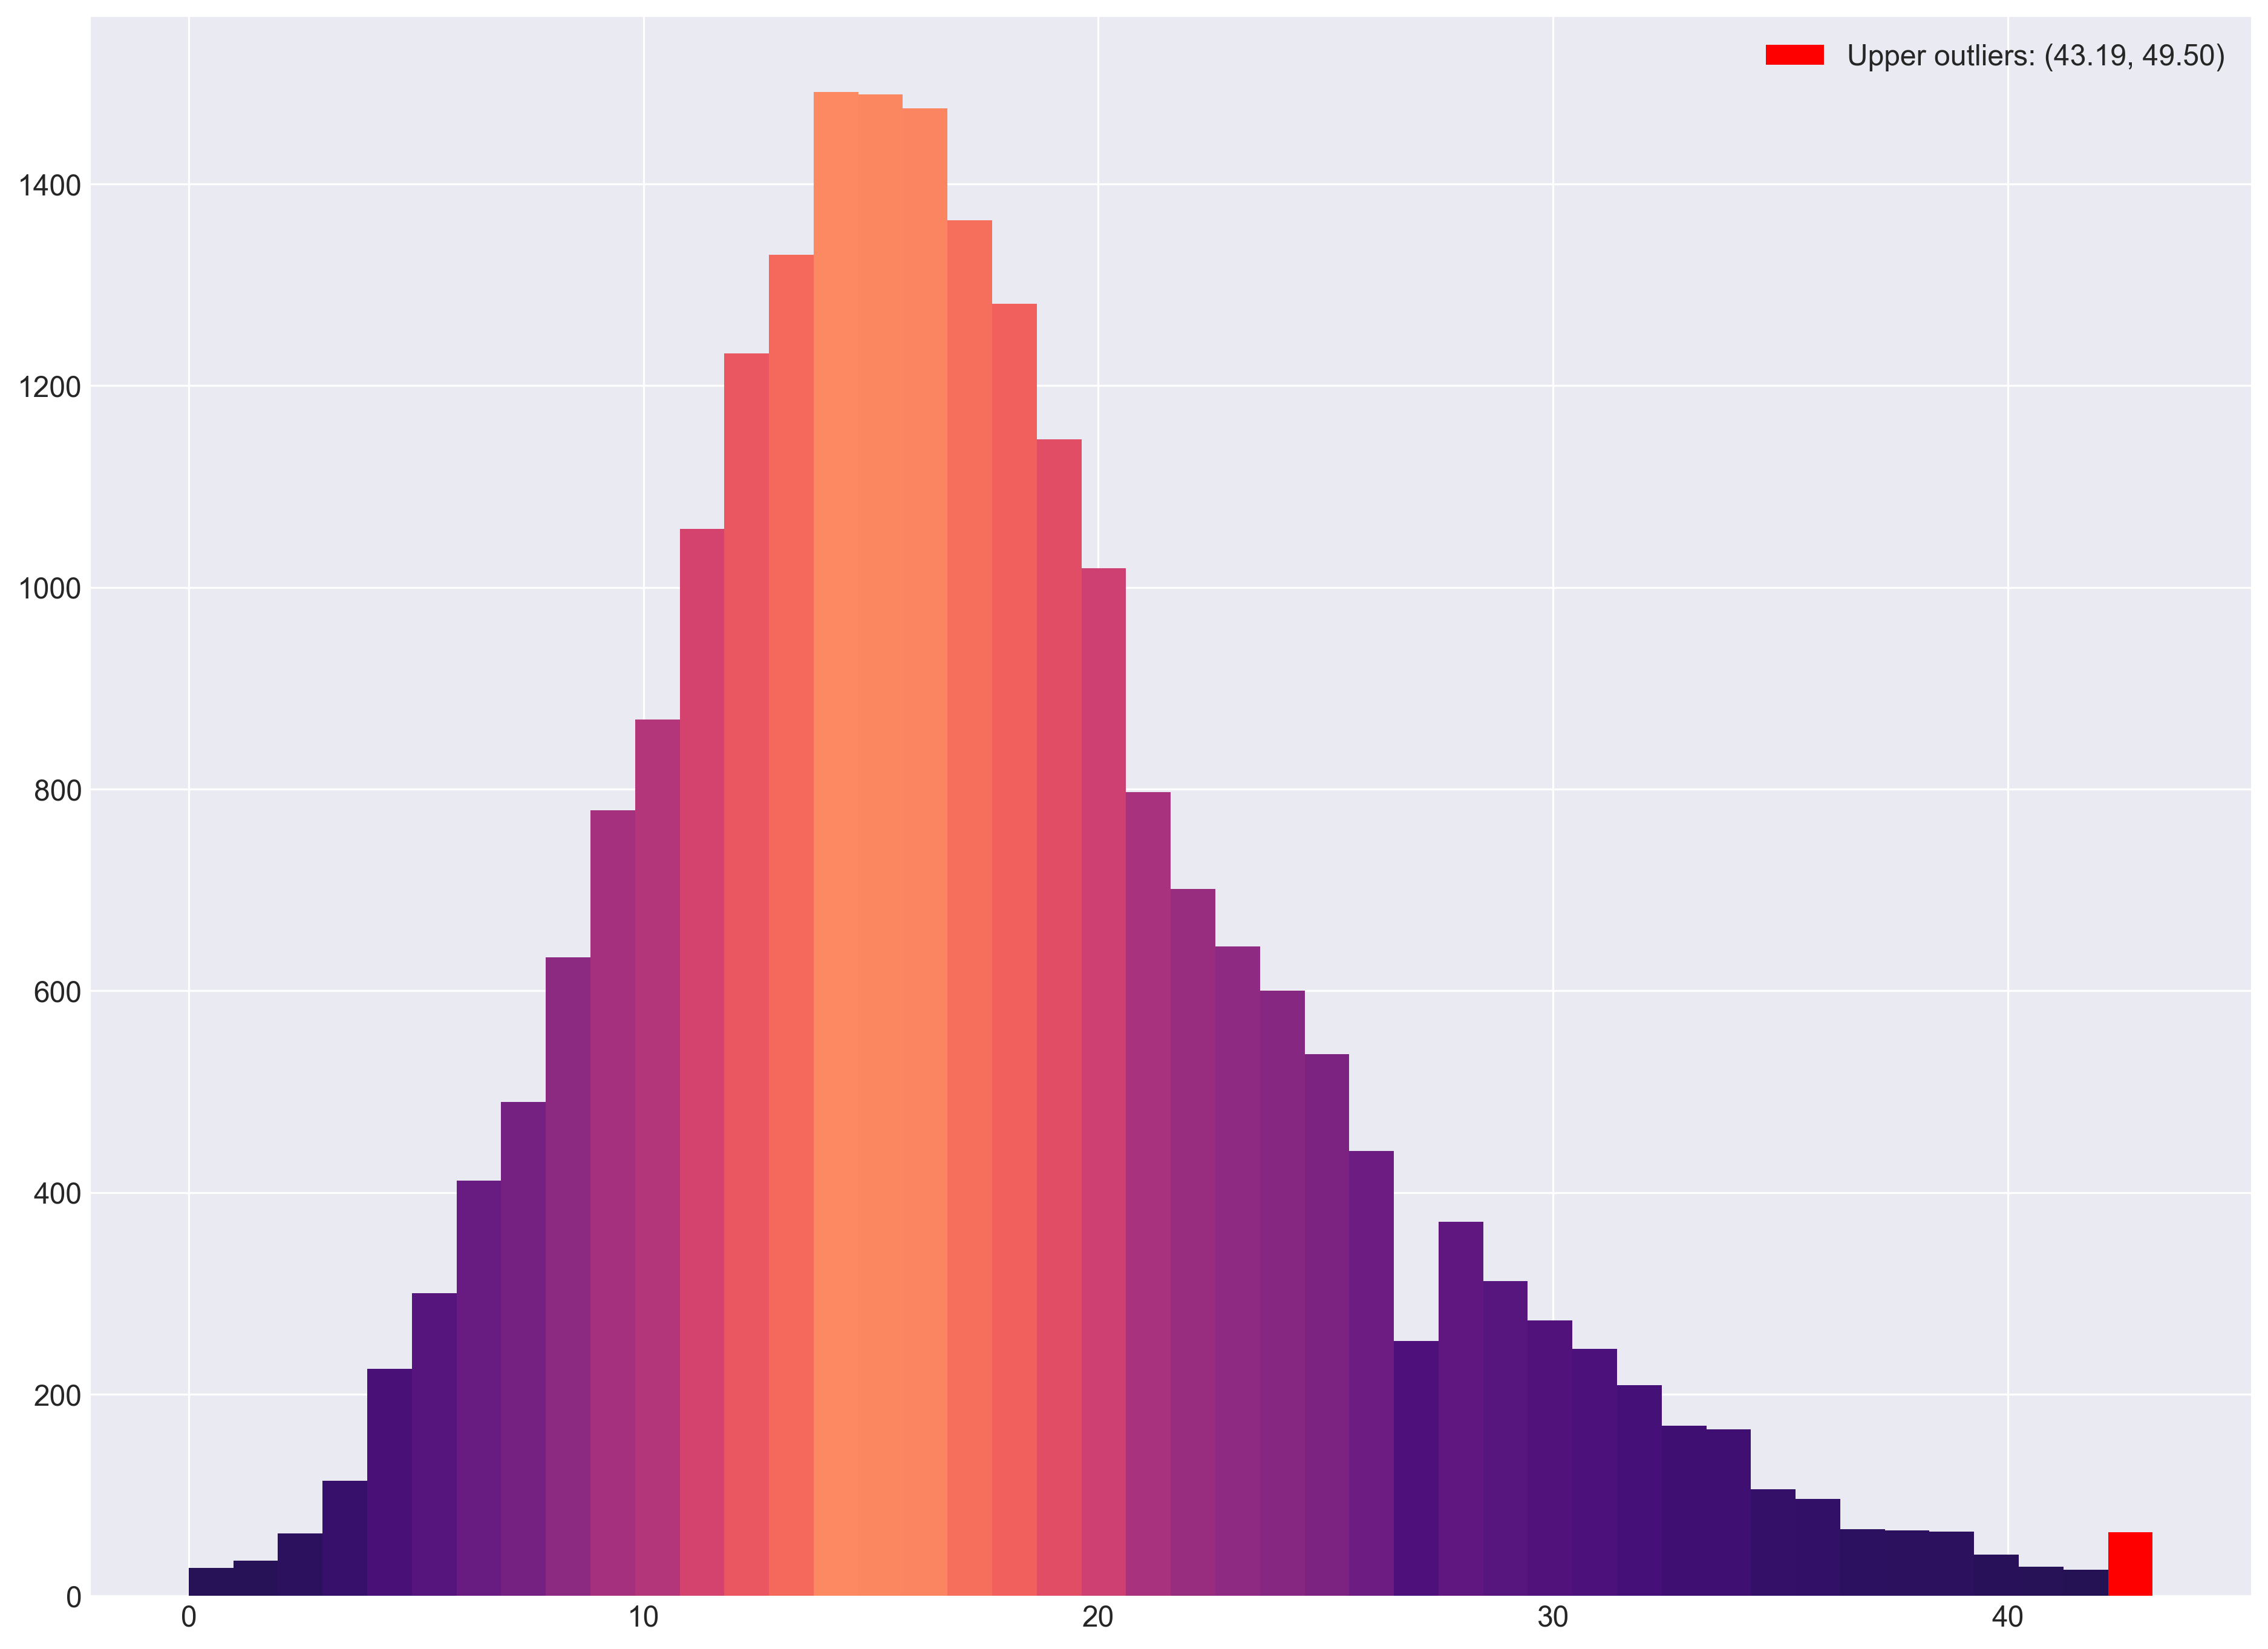

In [37]:
amsterdamumcdb.outliers_histogram(data=apache_ii['apache_ii_total_score'], bins=44).show()

In [38]:
apache_ii_total = apache_ii.apache_ii_total_score.median()
apache_ii_iqr1_total = apache_ii.apache_ii_total_score.quantile(0.25)
apache_ii_iqr2_total = apache_ii.apache_ii_total_score.quantile(0.75)

apache_ii_ICU = apache_ii.loc[apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].median()
apache_ii_iqr1_ICU = apache_ii.loc[apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_ICU = apache_ii.loc[apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.75)

apache_ii_MCU = apache_ii.loc[apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].median()
apache_ii_iqr1_MCU = apache_ii.loc[apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_MCU = apache_ii.loc[apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.75)

In [39]:
apache_ii_total_urgent = apache_ii.loc[apache_ii['urgency'] == 1].apache_ii_total_score.median()
apache_ii_iqr1_total_urgent = apache_ii.loc[apache_ii['urgency'] == 1].apache_ii_total_score.quantile(0.25)
apache_ii_iqr2_total_urgent = apache_ii.loc[apache_ii['urgency'] == 1].apache_ii_total_score.quantile(0.75)

apache_ii_ICU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].median()
apache_ii_iqr1_ICU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_ICU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.75)

apache_ii_MCU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].median()
apache_ii_iqr1_MCU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_MCU_urgent = apache_ii.loc[(apache_ii['urgency'] == 1) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.75)

In [40]:
apache_ii_total_nonurgent = apache_ii.loc[apache_ii['urgency'] == 0].apache_ii_total_score.median()
apache_ii_iqr1_total_nonurgent = apache_ii.loc[apache_ii['urgency'] == 0].apache_ii_total_score.quantile(0.25)
apache_ii_iqr2_total_nonurgent = apache_ii.loc[apache_ii['urgency'] == 0].apache_ii_total_score.quantile(0.75)

apache_ii_ICU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].median()
apache_ii_iqr1_ICU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_ICU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('IC'), 'apache_ii_total_score'].quantile(0.75)

apache_ii_MCU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].median()
apache_ii_iqr1_MCU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.25)
apache_ii_iqr2_MCU_nonurgent = apache_ii.loc[(apache_ii['urgency'] == 0) & apache_ii['location'].str.contains('^MC$'), 'apache_ii_total_score'].quantile(0.75)

### SOFA
Uses the `sofa.csv` file containing a SOFA score ([Vincent et al., 1996](http://link.springer.com/10.1007/BF01709751)) at day 1 (=first 24 hours of ICU/MCU admission) for all patients, created by the [sofa.ipynb](../concepts/severityscores/sofa.ipynb) notebook. See the notebook for detailed information about the score including data processing and score calculation.

In [41]:
sofa = pd.read_csv('../concepts/severityscores/sofa.csv')
sofa.head()

,admissionid,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score,location,urgency
0,0,3.0,0.0,NaN,1.0,0.0,0.0,4.0,IC,0
1,1,2.0,1.0,NaN,2.0,0.0,0.0,5.0,IC,0
2,2,2.0,0.0,NaN,4.0,0.0,0.0,6.0,IC,1
3,3,2.0,0.0,NaN,0.0,NaN,1.0,3.0,IC,0
4,4,3.0,0.0,0.0,2.0,4.0,0.0,9.0,IC&MC,0


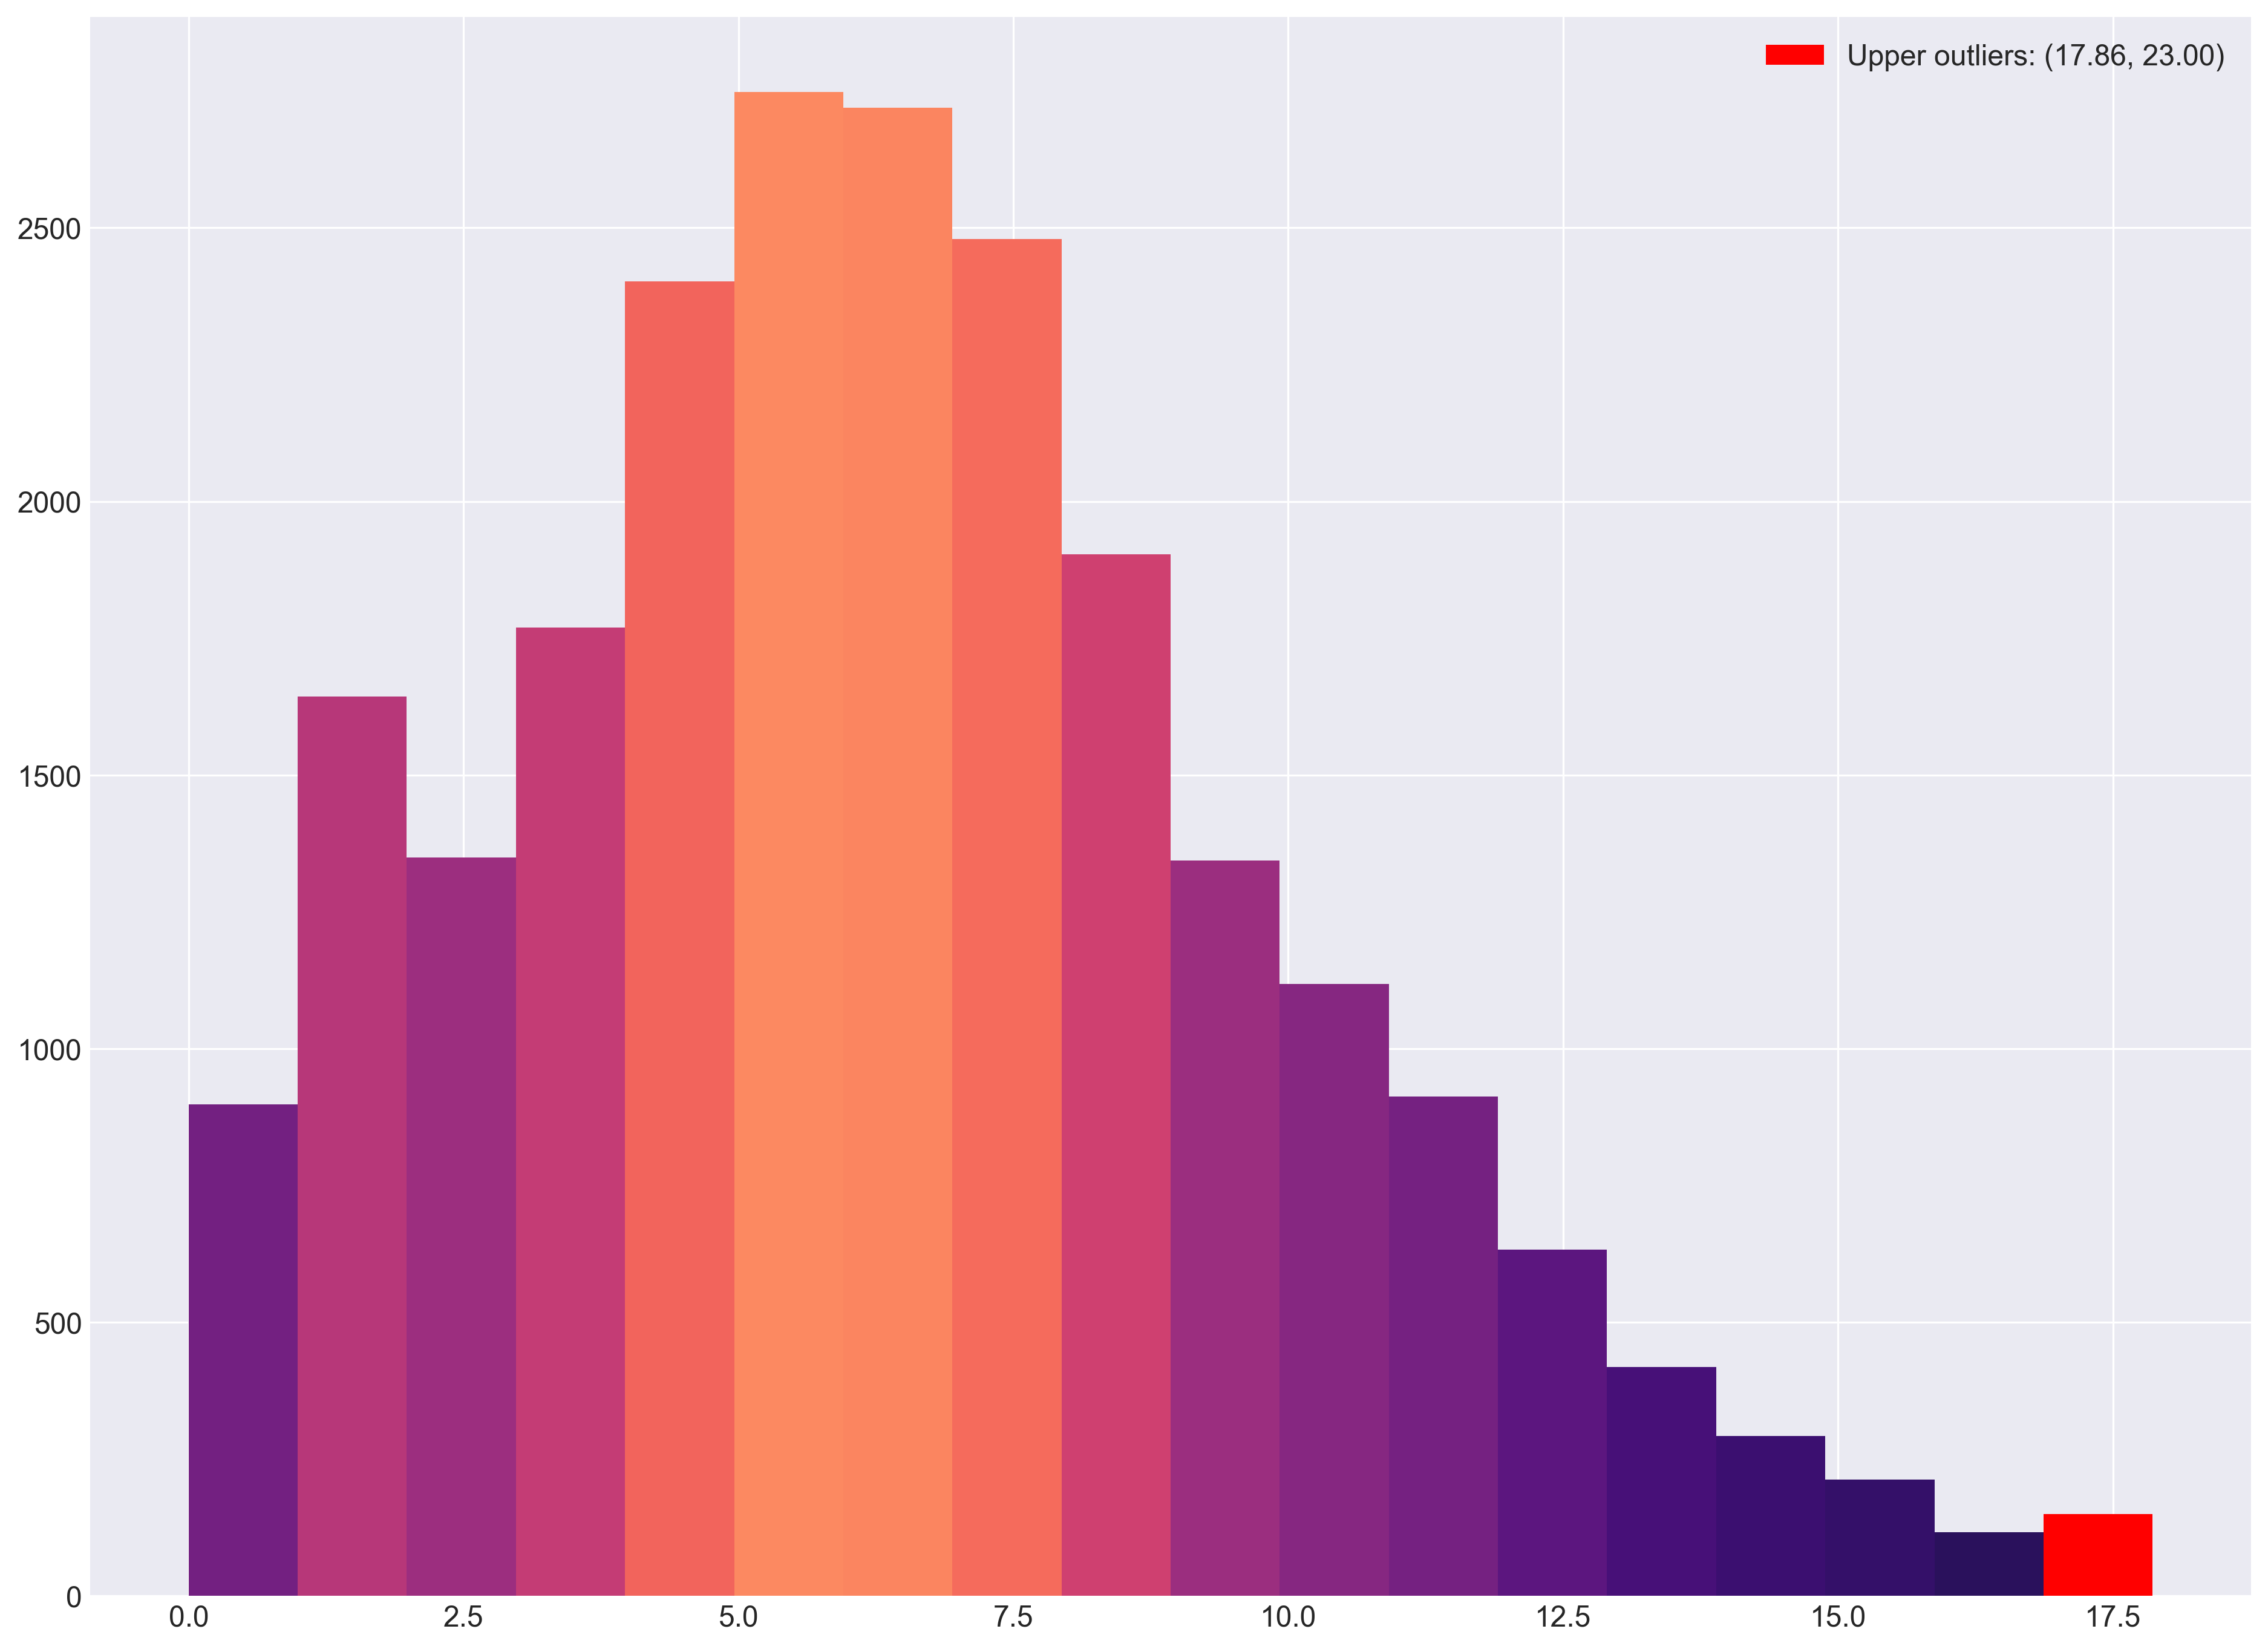

In [42]:
amsterdamumcdb.outliers_histogram(data=sofa['sofa_total_score'],bins=18).show()

In [43]:
sofa_total = sofa.sofa_total_score.median()
sofa_iqr1_total = sofa.sofa_total_score.quantile(0.25)
sofa_iqr2_total = sofa.sofa_total_score.quantile(0.75)

sofa_ICU = sofa.loc[sofa['location'].str.contains('IC'), 'sofa_total_score'].median()
sofa_iqr1_ICU = sofa.loc[sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_ICU = sofa.loc[sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.75)

sofa_MCU = sofa.loc[sofa['location'].str.contains('^MC$'), 'sofa_total_score'].median()
sofa_iqr1_MCU = sofa.loc[sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_MCU = sofa.loc[sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.75)

In [44]:
sofa_total_urgent = sofa.loc[sofa['urgency'] == 1].sofa_total_score.median()
sofa_iqr1_total_urgent = sofa.loc[sofa['urgency'] == 1].sofa_total_score.quantile(0.25)
sofa_iqr2_total_urgent = sofa.loc[sofa['urgency'] == 1].sofa_total_score.quantile(0.75)

sofa_ICU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('IC'), 'sofa_total_score'].median()
sofa_iqr1_ICU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_ICU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.75)

sofa_MCU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].median()
sofa_iqr1_MCU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_MCU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.75)

In [45]:
sofa_total_nonurgent = sofa.loc[sofa['urgency'] == 0].sofa_total_score.median()
sofa_iqr1_total_nonurgent = sofa.loc[sofa['urgency'] == 0].sofa_total_score.quantile(0.25)
sofa_iqr2_total_nonurgent = sofa.loc[sofa['urgency'] == 0].sofa_total_score.quantile(0.75)

sofa_ICU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('IC'), 'sofa_total_score'].median()
sofa_iqr1_ICU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_ICU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.75)

sofa_MCU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].median()
sofa_iqr1_MCU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_MCU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.75)

## Create the actual table in html

In [46]:
display(Markdown("""
<table>
    <thead>
        <tr>
            <th style="text-align:left;">Patient Characteristics</th>
            <th style="text-align:right;">Total</th>
            <th style="text-align:right;">ICU</th>
            <th style="text-align:right;">MCU</th>
        </tr>
        <tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">Distinct patients, no.</td>
            <td>{no_patients_total}</td>
            <td>{no_patients_ICU}</td>
            <td>{no_patients_MCU}</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU admissions, no.</td>
            <td>{no_admissions_total}</td>
            <td>{no_admissions_ICU}</td>
            <td>{no_admissions_MCU}</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU length of stay, days (median [IQR])</td>
            <td>{los_total:.2f} [{los_iqr1_total:.2f}, {los_iqr2_total:.2f}]</td>
            <td>{los_ICU:.2f} [{los_iqr1_ICU:.2f}, {los_iqr2_ICU:.2f}]</td>
            <td>{los_MCU:.2f} [{los_iqr1_MCU:.2f}, {los_iqr2_MCU:.2f}]</td>
        </tr>    
        <tr>
            <th style="text-align:left" colspan=4>Gender</th>
        </tr>    
        <tr>
            <td style="text-align:left">Male, no. (%)</td>
            <td>{male_total} ({male_pct_total:.2f})</td>
            <td>{male_ICU} ({male_pct_ICU:.2f})</td>
            <td>{male_MCU} ({male_pct_MCU:.2f})</td>
        </tr>    
        <tr>          
            <td style="text-align:left">Female, no. (%)</td>
            <td>{female_total} ({female_pct_total:.2f})</td>
            <td>{female_ICU} ({female_pct_ICU:.2f})</td>
            <td>{female_MCU} ({female_pct_MCU:.2f})</td>
        </tr>    
        <tr>
            <td style="text-align:left">Unknown gender, no. (%)</td>
            <td>{gender_na_total} ({gender_na_pct_total:.2f})</td>
            <td>{gender_na_ICU} ({gender_na_pct_ICU:.2f})</td>
            <td>{gender_na_MCU} ({gender_na_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Age</th>
        </tr>
        <tr>
            <td style="text-align:left">18-39 years, no. (%)</td>
            <td>{age_18_39_total} ({age_18_39_pct_total:.2f})
            <td>{age_18_39_ICU} ({age_18_39_pct_ICU:.2f})
            <td>{age_18_39_MCU} ({age_18_39_pct_MCU:.2f})
        </tr>
        <tr>
            <td style="text-align:left">40-49 years, no. (%)</td>
            <td>{age_40_49_total} ({age_40_49_pct_total:.2f})
            <td>{age_40_49_ICU} ({age_40_49_pct_ICU:.2f})
            <td>{age_40_49_MCU} ({age_40_49_pct_MCU:.2f})
        </tr>
        <tr>
            <td style="text-align:left">50-59 years, no. (%)</td>
            <td>{age_50_59_total} ({age_50_59_pct_total:.2f})
            <td>{age_50_59_ICU} ({age_50_59_pct_ICU:.2f})
            <td>{age_50_59_MCU} ({age_50_59_pct_MCU:.2f})
        </tr>
        <tr>
            <td style="text-align:left">60-69 years, no. (%)</td>
            <td>{age_60_69_total} ({age_60_69_pct_total:.2f})
            <td>{age_60_69_ICU} ({age_60_69_pct_ICU:.2f})
            <td>{age_60_69_MCU} ({age_60_69_pct_MCU:.2f})
        </tr>
        <tr>
            <td style="text-align:left">70-79 years, no. (%)</td>
            <td>{age_70_79_total} ({age_70_79_pct_total:.2f})
            <td>{age_70_79_ICU} ({age_70_79_pct_ICU:.2f})
            <td>{age_70_79_MCU} ({age_70_79_pct_MCU:.2f})
        </tr>
        <tr>
            <td style="text-align:left">80+ years, no. (%)</td>
            <td>{age_80_total} ({age_80_pct_total:.2f})
            <td>{age_80_ICU} ({age_80_pct_ICU:.2f})
            <td>{age_80_MCU} ({age_80_pct_MCU:.2f})
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Admission Year</th>
        </tr>
        <tr>
            <td style="text-align:left">2003-2009, no. (%)</td>
            <td>{admission_year_2003_total} ({admission_year_2003_pct_total:.2f})
            <td>{admission_year_2003_ICU} ({admission_year_2003_pct_ICU:.2f})
            <td>{admission_year_2003_MCU} ({admission_year_2003_pct_MCU:.2f})
        </tr>
        <tr>
            <td style="text-align:left">2010-2016, no. (%)</td>
            <td>{admission_year_2010_total} ({admission_year_2010_pct_total:.2f})
            <td>{admission_year_2010_ICU} ({admission_year_2010_pct_ICU:.2f})
            <td>{admission_year_2010_MCU} ({admission_year_2010_pct_MCU:.2f})
        <tr>
            <th style="text-align:left" colspan=4>Admission type</th>
        </tr>
        <tr>
            <td style="text-align:left">Surgical admissions, no. (%)</td>
            <td>{surgical_total} ({surgical_pct_total:.2f})</td>
            <td>{surgical_ICU} ({surgical_pct_ICU:.2f})</td>
            <td>{surgical_MCU} ({surgical_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Medical admissions, no. (%)</td>
            <td>{medical_total} ({medical_pct_total:.2f})</td>
            <td>{medical_ICU} ({medical_pct_ICU:.2f})</td>
            <td>{medical_MCU} ({medical_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Surgical/Medical Unknown, no. (%)</td>
            <td>{medical_surgical_na_total} ({medical_surgical_na_pct_total:.2f})</td>
            <td>{medical_surgical_na_ICU} ({medical_surgical_na_pct_ICU:.2f})</td>
            <td>{medical_surgical_na_MCU} ({medical_surgical_na_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Urgent admissions, no. (%)</td>
            <td>{urgency_total} ({urgency_pct_total:.2f})</td>
            <td>{urgency_ICU} ({urgency_pct_ICU:.2f})</td>
            <td>{urgency_MCU} ({urgency_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Reason for admission</td>
        </tr>
        <tr>
            <td style="text-align:left">Cardiac surgery, no (%)</td>
            <td>{reason_car_surg_total} ({reason_car_surg_pct_total:.2f})</td>
            <td>{reason_car_surg_ICU} ({reason_car_surg_pct_ICU:.2f})</td>
            <td>{reason_car_surg_MCU} ({reason_car_surg_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Neurosurgery, no. (%)</td>
            <td>{reason_neu_surg_total} ({reason_neu_surg_pct_total:.2f})</td>
            <td>{reason_neu_surg_ICU} ({reason_neu_surg_pct_ICU:.2f})</td>
            <td>{reason_neu_surg_MCU} ({reason_neu_surg_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Gastro-intestinal surgery, no. (%)</td>
            <td>{reason_gi_surg_total} ({reason_gi_surg_pct_total:.2f})</td>
            <td>{reason_gi_surg_ICU} ({reason_gi_surg_pct_ICU:.2f})</td>
            <td>{reason_gi_surg_MCU} ({reason_gi_surg_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Cardiac arrest, no. (%)</td>
            <td>{reason_car_arrest_total} ({reason_car_arrest_pct_total:.2f})</td>
            <td>{reason_car_arrest_ICU} ({reason_car_arrest_pct_ICU:.2f})</td>
            <td>{reason_car_arrest_MCU} ({reason_car_arrest_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Vascular surgery, no. (%)</td>
            <td>{reason_vasc_surg_total} ({reason_vasc_surg_pct_total:.2f})</td>
            <td>{reason_vasc_surg_ICU} ({reason_vasc_surg_pct_ICU:.2f})</td>
            <td>{reason_vasc_surg_MCU} ({reason_vasc_surg_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Trauma, no. (%)</td>
            <td>{reason_trauma_total} ({reason_trauma_pct_total:.2f})</td>
            <td>{reason_trauma_ICU} ({reason_trauma_pct_ICU:.2f})</td>
            <td>{reason_trauma_MCU} ({reason_trauma_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Sepsis, no. (%)</td>
            <td>{reason_sepsis_total} ({reason_sepsis_pct_total:.2f})</td>
            <td>{reason_sepsis_ICU} ({reason_sepsis_pct_ICU:.2f})</td>
            <td>{reason_sepsis_MCU} ({reason_sepsis_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Respiratory failure, no. (%)</td>
            <td>{reason_resp_failure_total} ({reason_resp_failure_pct_total:.2f})</td>
            <td>{reason_resp_failure_ICU} ({reason_resp_failure_pct_ICU:.2f})</td>
            <td>{reason_resp_failure_MCU} ({reason_resp_failure_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Supportive therapies</td>
        </tr>
        <tr>
            <td style="text-align:left">Vasopressors and inotropes, no. (%)</td>
            <td>{vaso_ino_total} ({vaso_ino_pct_total:.2f})</td>
            <td>{vaso_ino_ICU} ({vaso_ino_pct_ICU:.2f})</td>
            <td>{vaso_ino_MCU} ({vaso_ino_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Mechanical ventilation, no. (%)</td>
            <td>{mv_total} ({mv_pct_total:.2f})</td>
            <td>{mv_ICU} ({mv_pct_ICU:.2f})</td>
            <td>{mv_MCU} ({mv_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Renal replacement therapy, no. (%)</td>
            <td>{renal_replacement_total} ({renal_replacement_pct_total:.2f})</td>
            <td>{renal_replacement_ICU} ({renal_replacement_pct_ICU:.2f})</td>
            <td>{renal_replacement_MCU} ({renal_replacement_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Outcome</th>
        </tr>
        <tr>
            <td style="text-align:left">Survival at unit discharge, no. (%)</td>
            <td>{alive_total} ({alive_pct_total:.2f})</td>
            <td>{alive_ICU}({alive_pct_ICU:.2f})</td>
            <td>{alive_MCU} ({alive_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Death at unit discharge, no. (%)</td>
            <td>{expired_total} ({expired_pct_total:.2f})</td>
            <td>{expired_ICU} ({expired_pct_ICU:.2f})</td>
            <td>{expired_MCU} ({expired_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Survival status unknown, no. (%)</td>
            <td>{alive_na_total} ({alive_na_pct_total:.2f})</td>
            <td>{alive_na_ICU} ({alive_na_pct_ICU:.2f})</td>
            <td>{alive_na_MCU} ({alive_na_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <td style="text-align:left">Death < 1 year after discharge, no. (%)</td>
            <td>{expired_1y_total} ({expired_1y_pct_total:.2f})</td>
            <td>{expired_1y_ICU} ({expired_1y_pct_ICU:.2f})</td>
            <td>{expired_1y_MCU} ({expired_1y_pct_MCU:.2f})</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Severity Scores</th>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Urgent patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>{apache_ii_total_urgent:.0f} [{apache_ii_iqr1_total_urgent:.0f}, {apache_ii_iqr2_total_urgent:.0f}]</td>
            <td>{apache_ii_ICU_urgent:.0f} [{apache_ii_iqr1_ICU_urgent:.0f}, {apache_ii_iqr2_ICU_urgent:.0f}]</td>
            <td>{apache_ii_MCU_urgent:.0f} [{apache_ii_iqr1_MCU_urgent:.0f}, {apache_ii_iqr2_MCU_urgent:.0f}]</td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>{sofa_total_urgent:.0f} [{sofa_iqr1_total_urgent:.0f}, {sofa_iqr2_total_urgent:.0f}]</td>
            <td>{sofa_ICU_urgent:.0f} [{sofa_iqr1_ICU_urgent:.0f}, {sofa_iqr2_ICU_urgent:.0f}]</td>
            <td>{sofa_MCU_urgent:.0f} [{sofa_iqr1_MCU_urgent:.0f}, {sofa_iqr2_MCU_urgent:.0f}]</td>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Elective patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>{apache_ii_total_nonurgent:.0f} [{apache_ii_iqr1_total_nonurgent:.0f}, {apache_ii_iqr2_total_nonurgent:.0f}]</td>
            <td>{apache_ii_ICU_nonurgent:.0f} [{apache_ii_iqr1_ICU_nonurgent:.0f}, {apache_ii_iqr2_ICU_nonurgent:.0f}]</td>
            <td>{apache_ii_MCU_nonurgent:.0f} [{apache_ii_iqr1_MCU_nonurgent:.0f}, {apache_ii_iqr2_MCU_nonurgent:.0f}]</td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>{sofa_total_nonurgent:.0f} [{sofa_iqr1_total_nonurgent:.0f}, {sofa_iqr2_total_nonurgent:.0f}]</td>
            <td>{sofa_ICU_nonurgent:.0f} [{sofa_iqr1_ICU_nonurgent:.0f}, {sofa_iqr2_ICU_nonurgent:.0f}]</td>
            <td>{sofa_MCU_nonurgent:.0f} [{sofa_iqr1_MCU_nonurgent:.0f}, {sofa_iqr2_MCU_nonurgent:.0f}]</td>
        </tr>
    </tbody>
</table>
""".format(
            #No. patients
            no_patients_total = no_patients_total,
            no_patients_ICU = no_patients_ICU,
            no_patients_MCU = no_patients_MCU,

            #No. admissions
            no_admissions_total = no_admissions_total,
            no_admissions_ICU = no_admissions_ICU,
            no_admissions_MCU = no_admissions_MCU,

            #Length of stay
            los_total = los_total,
            los_iqr1_total = los_iqr1_total,
            los_iqr2_total = los_iqr2_total,

            los_ICU = los_ICU,
            los_iqr1_ICU = los_iqr1_ICU,
            los_iqr2_ICU = los_iqr2_ICU,

            los_MCU = los_MCU,
            los_iqr1_MCU = los_iqr1_MCU,
            los_iqr2_MCU = los_iqr2_MCU,

            #Gender
            ## Male
            male_total = male_total,
            male_pct_total = male_pct_total,

            male_ICU = male_ICU,
            male_pct_ICU = male_pct_ICU,

            male_MCU = male_MCU,
            male_pct_MCU = male_pct_MCU,


            ## Female
            female_total = female_total,
            female_pct_total = female_pct_total,

            female_ICU = female_ICU,
            female_pct_ICU = female_pct_ICU,

            female_MCU = female_MCU,
            female_pct_MCU = female_pct_MCU,

            ## Unknown
            gender_na_total = gender_na_total,
            gender_na_pct_total = gender_na_pct_total,

            gender_na_ICU = gender_na_ICU,
            gender_na_pct_ICU = gender_na_pct_ICU,

            gender_na_MCU = gender_na_MCU,
            gender_na_pct_MCU = gender_na_pct_MCU,

            #age
            ## 18-39
            age_18_39_total = age_18_39_total,
            age_18_39_pct_total = age_18_39_pct_total,
    
            age_18_39_ICU = age_18_39_ICU,
            age_18_39_pct_ICU = age_18_39_pct_ICU,
    
            age_18_39_MCU = age_18_39_MCU,
            age_18_39_pct_MCU = age_18_39_pct_MCU,

            ## 40-49
            age_40_49_total = age_40_49_total,
            age_40_49_pct_total = age_40_49_pct_total,
    
            age_40_49_ICU = age_40_49_ICU,
            age_40_49_pct_ICU = age_40_49_pct_ICU,
    
            age_40_49_MCU = age_40_49_MCU,
            age_40_49_pct_MCU = age_40_49_pct_MCU,


            ## 50-59
            age_50_59_total = age_50_59_total,
            age_50_59_pct_total = age_50_59_pct_total,
    
            age_50_59_ICU = age_50_59_ICU,
            age_50_59_pct_ICU = age_50_59_pct_ICU,
    
            age_50_59_MCU = age_50_59_MCU,
            age_50_59_pct_MCU = age_50_59_pct_MCU,


            ## 60-69
            age_60_69_total = age_60_69_total,
            age_60_69_pct_total = age_60_69_pct_total,
    
            age_60_69_ICU = age_60_69_ICU,
            age_60_69_pct_ICU = age_60_69_pct_ICU,
    
            age_60_69_MCU = age_60_69_MCU,
            age_60_69_pct_MCU = age_60_69_pct_MCU,

            ## 70-79
            age_70_79_total = age_70_79_total,
            age_70_79_pct_total = age_70_79_pct_total,
    
            age_70_79_ICU = age_70_79_ICU,
            age_70_79_pct_ICU = age_70_79_pct_ICU,
    
            age_70_79_MCU = age_70_79_MCU,
            age_70_79_pct_MCU = age_70_79_pct_MCU,

            ## 80+
            age_80_total = age_80_total,
            age_80_pct_total = age_80_pct_total,
            age_80_ICU = age_80_ICU,
    
            age_80_pct_ICU = age_80_pct_ICU,
            age_80_MCU = age_80_MCU,
            age_80_pct_MCU = age_80_pct_MCU,
    
            #admission year
            admission_year_2003_total = admission_year_2003_total,
            admission_year_2003_pct_total = admission_year_2003_pct_total,
            admission_year_2003_ICU = admission_year_2003_ICU,
            admission_year_2003_pct_ICU = admission_year_2003_pct_ICU,
            admission_year_2003_MCU = admission_year_2003_MCU,
            admission_year_2003_pct_MCU = admission_year_2003_pct_MCU,

            admission_year_2010_total = admission_year_2010_total,
            admission_year_2010_pct_total = admission_year_2010_pct_total,
            admission_year_2010_ICU = admission_year_2010_ICU,
            admission_year_2010_pct_ICU = admission_year_2010_pct_ICU,
            admission_year_2010_MCU = admission_year_2010_MCU,
            admission_year_2010_pct_MCU = admission_year_2010_pct_MCU,
    
            #surgical
            surgical_total = surgical_total,
            surgical_pct_total = surgical_pct_total,

            surgical_ICU = surgical_ICU,
            surgical_pct_ICU = surgical_pct_ICU,

            surgical_MCU = surgical_MCU,
            surgical_pct_MCU = surgical_pct_MCU,


            #medical
            medical_total = medical_total,
            medical_pct_total = medical_pct_total,

            medical_ICU = medical_ICU,
            medical_pct_ICU = medical_pct_ICU,

            medical_MCU = medical_MCU,
            medical_pct_MCU = medical_pct_MCU,

            #surgical/medical unknown
            medical_surgical_na_total = medical_surgical_na_total,
            medical_surgical_na_pct_total = medical_surgical_na_pct_total,

            medical_surgical_na_ICU = medical_surgical_na_ICU,
            medical_surgical_na_pct_ICU = medical_surgical_na_pct_ICU,

            medical_surgical_na_MCU = medical_surgical_na_MCU,
            medical_surgical_na_pct_MCU = medical_surgical_na_pct_MCU,

            #urgency
            urgency_total = urgency_total,
            urgency_pct_total = urgency_pct_total,

            urgency_ICU = urgency_ICU,
            urgency_pct_ICU = urgency_pct_ICU,

            urgency_MCU = urgency_MCU,
            urgency_pct_MCU = urgency_pct_MCU,

            #reason for admission

            ## cardiac surgery
            reason_car_surg_total = reason_car_surg_total,
            reason_car_surg_pct_total = reason_car_surg_pct_total,
            reason_car_surg_ICU = reason_car_surg_ICU,
            reason_car_surg_pct_ICU = reason_car_surg_pct_ICU,
            reason_car_surg_MCU = reason_car_surg_MCU,
            reason_car_surg_pct_MCU = reason_car_surg_pct_MCU,

            ## neurosurgery
            reason_neu_surg_total = reason_neu_surg_total,
            reason_neu_surg_pct_total = reason_neu_surg_pct_total,
            reason_neu_surg_ICU = reason_neu_surg_ICU,
            reason_neu_surg_pct_ICU = reason_neu_surg_pct_ICU,
            reason_neu_surg_MCU = reason_neu_surg_MCU,
            reason_neu_surg_pct_MCU = reason_neu_surg_pct_MCU,

            ## gastro-intestinal surgery
            reason_gi_surg_total = reason_gi_surg_total,
            reason_gi_surg_pct_total = reason_gi_surg_pct_total,
            reason_gi_surg_ICU = reason_gi_surg_ICU,
            reason_gi_surg_pct_ICU = reason_gi_surg_pct_ICU,
            reason_gi_surg_MCU = reason_gi_surg_MCU,
            reason_gi_surg_pct_MCU = reason_gi_surg_pct_MCU,

            ## cardiac arrest
            reason_car_arrest_total = reason_car_arrest_total,
            reason_car_arrest_pct_total = reason_car_arrest_pct_total,
            reason_car_arrest_ICU = reason_car_arrest_ICU,
            reason_car_arrest_pct_ICU = reason_car_arrest_pct_ICU,
            reason_car_arrest_MCU = reason_car_arrest_MCU,
            reason_car_arrest_pct_MCU = reason_car_arrest_pct_MCU,

            ## vascular surgery
            reason_vasc_surg_total = reason_vasc_surg_total,
            reason_vasc_surg_pct_total = reason_vasc_surg_pct_total,
            reason_vasc_surg_ICU = reason_vasc_surg_ICU,
            reason_vasc_surg_pct_ICU = reason_vasc_surg_pct_ICU,
            reason_vasc_surg_MCU = reason_vasc_surg_MCU,
            reason_vasc_surg_pct_MCU = reason_vasc_surg_pct_MCU,

            ## trauma
            reason_trauma_total = reason_trauma_total,
            reason_trauma_pct_total = reason_trauma_pct_total,
            reason_trauma_ICU = reason_trauma_ICU,
            reason_trauma_pct_ICU = reason_trauma_pct_ICU,
            reason_trauma_MCU = reason_trauma_MCU,
            reason_trauma_pct_MCU = reason_trauma_pct_MCU,

            ## sepsis
            reason_sepsis_total = reason_sepsis_total,
            reason_sepsis_pct_total = reason_sepsis_pct_total,
            reason_sepsis_ICU = reason_sepsis_ICU,
            reason_sepsis_pct_ICU = reason_sepsis_pct_ICU,
            reason_sepsis_MCU = reason_sepsis_MCU,
            reason_sepsis_pct_MCU = reason_sepsis_pct_MCU,

            ## respiratory failure
            reason_resp_failure_total = reason_resp_failure_total,
            reason_resp_failure_pct_total = reason_resp_failure_pct_total,
            reason_resp_failure_ICU = reason_resp_failure_ICU,
            reason_resp_failure_pct_ICU = reason_resp_failure_pct_ICU,
            reason_resp_failure_MCU = reason_resp_failure_MCU,
            reason_resp_failure_pct_MCU = reason_resp_failure_pct_MCU,
    
            ## neurologic disorders
            reason_neuro_total = reason_neuro_total,
            reason_neuro_pct_total = reason_neuro_pct_total,
            reason_neuro_ICU = reason_neuro_ICU,
            reason_neuro_pct_ICU = reason_neuro_pct_ICU,
            reason_neuro_MCU = reason_neuro_MCU,
            reason_neuro_pct_MCU = reason_neuro_pct_MCU,
    
            ## cardiologic disorders
            reason_cardio_total = reason_cardio_total,
            reason_cardio_pct_total = reason_cardio_pct_total,
            reason_cardio_ICU = reason_cardio_ICU,
            reason_cardio_pct_ICU = reason_cardio_pct_ICU,
            reason_cardio_MCU = reason_cardio_MCU,
            reason_cardio_pct_MCU = reason_cardio_pct_MCU,
    
            #vasopressors and inotropes
            vaso_ino_total = vaso_ino_total,
            vaso_ino_pct_total = vaso_ino_pct_total,

            vaso_ino_ICU = vaso_ino_ICU,
            vaso_ino_pct_ICU = vaso_ino_pct_ICU,

            vaso_ino_MCU = vaso_ino_MCU,
            vaso_ino_pct_MCU = vaso_ino_pct_MCU,

            #mechanical ventilation
            mv_total = mv_total,
            mv_pct_total = mv_pct_total,

            mv_ICU = mv_ICU,
            mv_pct_ICU = mv_pct_ICU,

            mv_MCU = mv_MCU,
            mv_pct_MCU = mv_pct_MCU,

            #renal replacement therapy
            renal_replacement_total = renal_replacement_total,
            renal_replacement_pct_total = renal_replacement_pct_total,

            renal_replacement_ICU = renal_replacement_ICU,
            renal_replacement_pct_ICU = renal_replacement_pct_ICU,

            renal_replacement_MCU = renal_replacement_MCU,
            renal_replacement_pct_MCU = renal_replacement_pct_MCU,
            
            #Outcome measures
            alive_total = alive_total,
            alive_pct_total = alive_pct_total,

            alive_ICU = alive_ICU,
            alive_pct_ICU = alive_pct_ICU,

            alive_MCU = alive_MCU,
            alive_pct_MCU = alive_pct_MCU,

            expired_total = expired_total,
            expired_pct_total = expired_pct_total,

            expired_ICU = expired_ICU,
            expired_pct_ICU = expired_pct_ICU,

            expired_MCU = expired_MCU,
            expired_pct_MCU = expired_pct_MCU,

            alive_na_total = alive_na_total,
            alive_na_pct_total = alive_na_pct_total,

            alive_na_ICU = alive_na_ICU,
            alive_na_pct_ICU = alive_na_pct_ICU,

            alive_na_MCU = alive_na_MCU,
            alive_na_pct_MCU = alive_na_pct_MCU,

            expired_1y_total = expired_1y_total,
            expired_1y_pct_total = expired_1y_pct_total,

            expired_1y_ICU = expired_1y_ICU,
            expired_1y_pct_ICU = expired_1y_pct_ICU,

            expired_1y_MCU = expired_1y_MCU,
            expired_1y_pct_MCU = expired_1y_pct_MCU,
            
            #Severity scores
            #Urgent
            #APACHE II (Knaus, CCM, 1985)
            apache_ii_total_urgent = apache_ii_total_urgent,
            apache_ii_iqr1_total_urgent = apache_ii_iqr1_total_urgent,
            apache_ii_iqr2_total_urgent = apache_ii_iqr2_total_urgent,

            apache_ii_ICU_urgent = apache_ii_ICU_urgent,
            apache_ii_iqr1_ICU_urgent = apache_ii_iqr1_ICU_urgent,
            apache_ii_iqr2_ICU_urgent = apache_ii_iqr2_ICU_urgent,

            apache_ii_MCU_urgent = apache_ii_MCU_urgent,
            apache_ii_iqr1_MCU_urgent = apache_ii_iqr1_MCU_urgent,
            apache_ii_iqr2_MCU_urgent = apache_ii_iqr2_MCU_urgent,
    
            #SOFA (Vincent, ICM, 1996)
            sofa_total_urgent = sofa_total_urgent,
            sofa_iqr1_total_urgent = sofa_iqr1_total_urgent,
            sofa_iqr2_total_urgent = sofa_iqr2_total_urgent,

            sofa_ICU_urgent = sofa_ICU_urgent,
            sofa_iqr1_ICU_urgent = sofa_iqr1_ICU_urgent,
            sofa_iqr2_ICU_urgent = sofa_iqr2_ICU_urgent,

            sofa_MCU_urgent = sofa_MCU_urgent,
            sofa_iqr1_MCU_urgent = sofa_iqr1_MCU_urgent,
            sofa_iqr2_MCU_urgent = sofa_iqr2_MCU_urgent,
    
            ## Non-urgent
            #APACHE II (Knaus, CCM, 1985)
            apache_ii_total_nonurgent = apache_ii_total_nonurgent,
            apache_ii_iqr1_total_nonurgent = apache_ii_iqr1_total_nonurgent,
            apache_ii_iqr2_total_nonurgent = apache_ii_iqr2_total_nonurgent,

            apache_ii_ICU_nonurgent = apache_ii_ICU_nonurgent,
            apache_ii_iqr1_ICU_nonurgent = apache_ii_iqr1_ICU_nonurgent,
            apache_ii_iqr2_ICU_nonurgent = apache_ii_iqr2_ICU_nonurgent,

            apache_ii_MCU_nonurgent = apache_ii_MCU_nonurgent,
            apache_ii_iqr1_MCU_nonurgent = apache_ii_iqr1_MCU_nonurgent,
            apache_ii_iqr2_MCU_nonurgent = apache_ii_iqr2_MCU_nonurgent,
    
            #SOFA (Vincent, ICM, 1996)
            sofa_total_nonurgent = sofa_total_nonurgent,
            sofa_iqr1_total_nonurgent = sofa_iqr1_total_nonurgent,
            sofa_iqr2_total_nonurgent = sofa_iqr2_total_nonurgent,

            sofa_ICU_nonurgent = sofa_ICU_nonurgent,
            sofa_iqr1_ICU_nonurgent = sofa_iqr1_ICU_nonurgent,
            sofa_iqr2_ICU_nonurgent = sofa_iqr2_ICU_nonurgent,

            sofa_MCU_nonurgent = sofa_MCU_nonurgent,
            sofa_iqr1_MCU_nonurgent = sofa_iqr1_MCU_nonurgent,
            sofa_iqr2_MCU_nonurgent = sofa_iqr2_MCU_nonurgent
        )
    )
)


<table>
    <thead>
        <tr>
            <th style="text-align:left;">Patient Characteristics</th>
            <th style="text-align:right;">Total</th>
            <th style="text-align:right;">ICU</th>
            <th style="text-align:right;">MCU</th>
        </tr>
        <tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">Distinct patients, no.</td>
            <td>20109</td>
            <td>16518</td>
            <td>4295</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU admissions, no.</td>
            <td>23106</td>
            <td>18386</td>
            <td>4720</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU length of stay, days (median [IQR])</td>
            <td>1.08 [0.83, 3.67]</td>
            <td>1.25 [0.92, 4.71]</td>
            <td>0.83 [0.71, 1.62]</td>
        </tr>    
        <tr>
            <th style="text-align:left" colspan=4>Gender</th>
        </tr>    
        <tr>
            <td style="text-align:left">Male, no. (%)</td>
            <td>12799 (63.65)</td>
            <td>10565 (63.96)</td>
            <td>2234 (52.01)</td>
        </tr>    
        <tr>          
            <td style="text-align:left">Female, no. (%)</td>
            <td>6844 (34.03)</td>
            <td>5213 (31.56)</td>
            <td>1631 (37.97)</td>
        </tr>    
        <tr>
            <td style="text-align:left">Unknown gender, no. (%)</td>
            <td>466 (2.32)</td>
            <td>408 (2.47)</td>
            <td>58 (1.35)</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Age</th>
        </tr>
        <tr>
            <td style="text-align:left">18-39 years, no. (%)</td>
            <td>2202 (10.95)
            <td>1538 (9.31)
            <td>743 (17.30)
        </tr>
        <tr>
            <td style="text-align:left">40-49 years, no. (%)</td>
            <td>1897 (9.43)
            <td>1356 (8.21)
            <td>613 (14.27)
        </tr>
        <tr>
            <td style="text-align:left">50-59 years, no. (%)</td>
            <td>3405 (16.93)
            <td>2740 (16.59)
            <td>800 (18.63)
        </tr>
        <tr>
            <td style="text-align:left">60-69 years, no. (%)</td>
            <td>5272 (26.22)
            <td>4518 (27.35)
            <td>954 (22.21)
        </tr>
        <tr>
            <td style="text-align:left">70-79 years, no. (%)</td>
            <td>5293 (26.32)
            <td>4635 (28.06)
            <td>824 (19.19)
        </tr>
        <tr>
            <td style="text-align:left">80+ years, no. (%)</td>
            <td>2040 (10.14)
            <td>1731 (10.48)
            <td>361 (8.41)
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Admission Year</th>
        </tr>
        <tr>
            <td style="text-align:left">2003-2009, no. (%)</td>
            <td>8556 (42.55)
            <td>7940 (48.07)
            <td>809 (18.84)
        </tr>
        <tr>
            <td style="text-align:left">2010-2016, no. (%)</td>
            <td>11553 (57.45)
            <td>8578 (51.93)
            <td>3486 (81.16)
        <tr>
            <th style="text-align:left" colspan=4>Admission type</th>
        </tr>
        <tr>
            <td style="text-align:left">Surgical admissions, no. (%)</td>
            <td>11294 (48.88)</td>
            <td>8942 (48.63)</td>
            <td>2352 (49.83)</td>
        </tr>
        <tr>
            <td style="text-align:left">Medical admissions, no. (%)</td>
            <td>5818 (25.18)</td>
            <td>4776 (25.98)</td>
            <td>1042 (22.08)</td>
        </tr>
        <tr>
            <td style="text-align:left">Surgical/Medical Unknown, no. (%)</td>
            <td>5994 (25.94)</td>
            <td>4668 (25.39)</td>
            <td>1326 (28.09)</td>
        </tr>
        <tr>
            <td style="text-align:left">Urgent admissions, no. (%)</td>
            <td>6246 (27.03)</td>
            <td>4985 (27.11)</td>
            <td>1261 (26.72)</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Reason for admission</td>
        </tr>
        <tr>
            <td style="text-align:left">Cardiac surgery, no (%)</td>
            <td>5935 (25.69)</td>
            <td>5759 (31.32)</td>
            <td>176 (3.73)</td>
        </tr>
        <tr>
            <td style="text-align:left">Neurosurgery, no. (%)</td>
            <td>1619 (7.01)</td>
            <td>739 (4.02)</td>
            <td>880 (18.64)</td>
        </tr>
        <tr>
            <td style="text-align:left">Gastro-intestinal surgery, no. (%)</td>
            <td>1149 (4.97)</td>
            <td>800 (4.35)</td>
            <td>349 (7.39)</td>
        </tr>
        <tr>
            <td style="text-align:left">Cardiac arrest, no. (%)</td>
            <td>959 (4.15)</td>
            <td>958 (5.21)</td>
            <td>1 (0.02)</td>
        </tr>
        <tr>
            <td style="text-align:left">Vascular surgery, no. (%)</td>
            <td>1037 (4.49)</td>
            <td>791 (4.30)</td>
            <td>246 (5.21)</td>
        </tr>
        <tr>
            <td style="text-align:left">Trauma, no. (%)</td>
            <td>1243 (5.38)</td>
            <td>898 (4.88)</td>
            <td>345 (7.31)</td>
        </tr>
        <tr>
            <td style="text-align:left">Sepsis, no. (%)</td>
            <td>3136 (13.57)</td>
            <td>2751 (14.96)</td>
            <td>385 (8.16)</td>
        </tr>
        <tr>
            <td style="text-align:left">Respiratory failure, no. (%)</td>
            <td>1568 (6.79)</td>
            <td>1402 (7.63)</td>
            <td>166 (3.52)</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Supportive therapies</td>
        </tr>
        <tr>
            <td style="text-align:left">Vasopressors and inotropes, no. (%)</td>
            <td>13575 (58.75)</td>
            <td>12809 (69.67)</td>
            <td>766 (16.23)</td>
        </tr>
        <tr>
            <td style="text-align:left">Mechanical ventilation, no. (%)</td>
            <td>16680 (72.19)</td>
            <td>16305 (88.68)</td>
            <td>375 (7.94)</td>
        </tr>
        <tr>
            <td style="text-align:left">Renal replacement therapy, no. (%)</td>
            <td>1140 (4.93)</td>
            <td>1136 (6.18)</td>
            <td>4 (0.08)</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Outcome</th>
        </tr>
        <tr>
            <td style="text-align:left">Survival at unit discharge, no. (%)</td>
            <td>20598 (89.15)</td>
            <td>16165(87.92)</td>
            <td>4433 (93.92)</td>
        </tr>
        <tr>
            <td style="text-align:left">Death at unit discharge, no. (%)</td>
            <td>2288 (9.90)</td>
            <td>2216 (12.05)</td>
            <td>72 (1.53)</td>
        </tr>
        <tr>
            <td style="text-align:left">Survival status unknown, no. (%)</td>
            <td>220 (0.95)</td>
            <td>5 (0.03)</td>
            <td>215 (4.56)</td>
        </tr>
        <tr>
            <td style="text-align:left">Death < 1 year after discharge, no. (%)</td>
            <td>4730 (20.47)</td>
            <td>4002 (21.77)</td>
            <td>728 (15.42)</td>
        </tr>
        <tr>
            <th style="text-align:left" colspan=4>Severity Scores</th>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Urgent patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>19 [13, 26]</td>
            <td>21 [16, 27]</td>
            <td>12 [8, 16]</td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>7 [4, 10]</td>
            <td>8 [5, 10]</td>
            <td>2 [1, 4]</td>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Elective patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">APACHE II score (median [IQR])</td>
            <td>16 [12, 20]</td>
            <td>17 [14, 21]</td>
            <td>11 [8, 15]</td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>6 [4, 8]</td>
            <td>6 [4, 8]</td>
            <td>2 [1, 4]</td>
        </tr>
    </tbody>
</table>
